In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

# Dynamically determine the base directory relative to the notebook
BASE_DIR = Path.cwd().parent  # Moves up one level from the current notebook's directory

# Set the data folder path relative to the base directory
DATA_DIR = BASE_DIR / "data/train"

# Load datasets
datasets = {
    "agg_trades": pd.read_parquet(DATA_DIR / "agg_trades.parquet"),
    "orderbook_embedding": pd.read_parquet(DATA_DIR / "orderbook_embedding.parquet"),
    
    "orderbook_solusdt": pd.read_parquet(DATA_DIR / "orderbook_solusdt.parquet"),
    "target_data_solusdt": pd.read_parquet(DATA_DIR / "target_data_solusdt.parquet"),
    "target_solusdt": pd.read_parquet(DATA_DIR / "target_solusdt.parquet"),
}
# Constants for time conversions
NANOSECOND = 1
MICROSECOND = 1000
MILLISECOND = 1000000
SECOND = 1000000000



In [93]:
target_data_solusdt = datasets.get("target_data_solusdt")
target_solusdt = datasets.get("target_solusdt")
# print(index_comparison_summary)

target_solusdt_full = target_data_solusdt.merge(
    target_solusdt,
    left_index=True,
    right_index=True,
    how='outer'  # Choose 'inner' join for common rows; use 'outer', 'left', or 'right' as needed
)
# print(target_solusdt_full)

In [94]:
data_copy = target_solusdt_full
data = data_copy
data

side       price  amount    weight  target
timestamp_ns                                                   
1726617603492082000     1  131.466995     7.0  0.397396       0
1726617603512695000     1  131.466995     1.0  0.150202       0
1726617603512698000     1  131.466003     2.0  0.207696       0
1726617603543949000    -1  131.460007     8.0  0.433219       1
1726617603710144000     1  131.459000     1.0  0.120686       0
...                   ...         ...     ...       ...     ...
1727827199560359000     1  145.072998     3.0  0.021153       0
1727827199560366000     1  145.072006     1.0  0.029028       1
1727827199560372000     1  145.072006     3.0  0.050278       1
1727827199721740000     1  145.070999     9.0  0.129024       1
1727827199762003000    -1  145.072006   127.0  0.999216       1

[9163347 rows x 5 columns]

# pictures

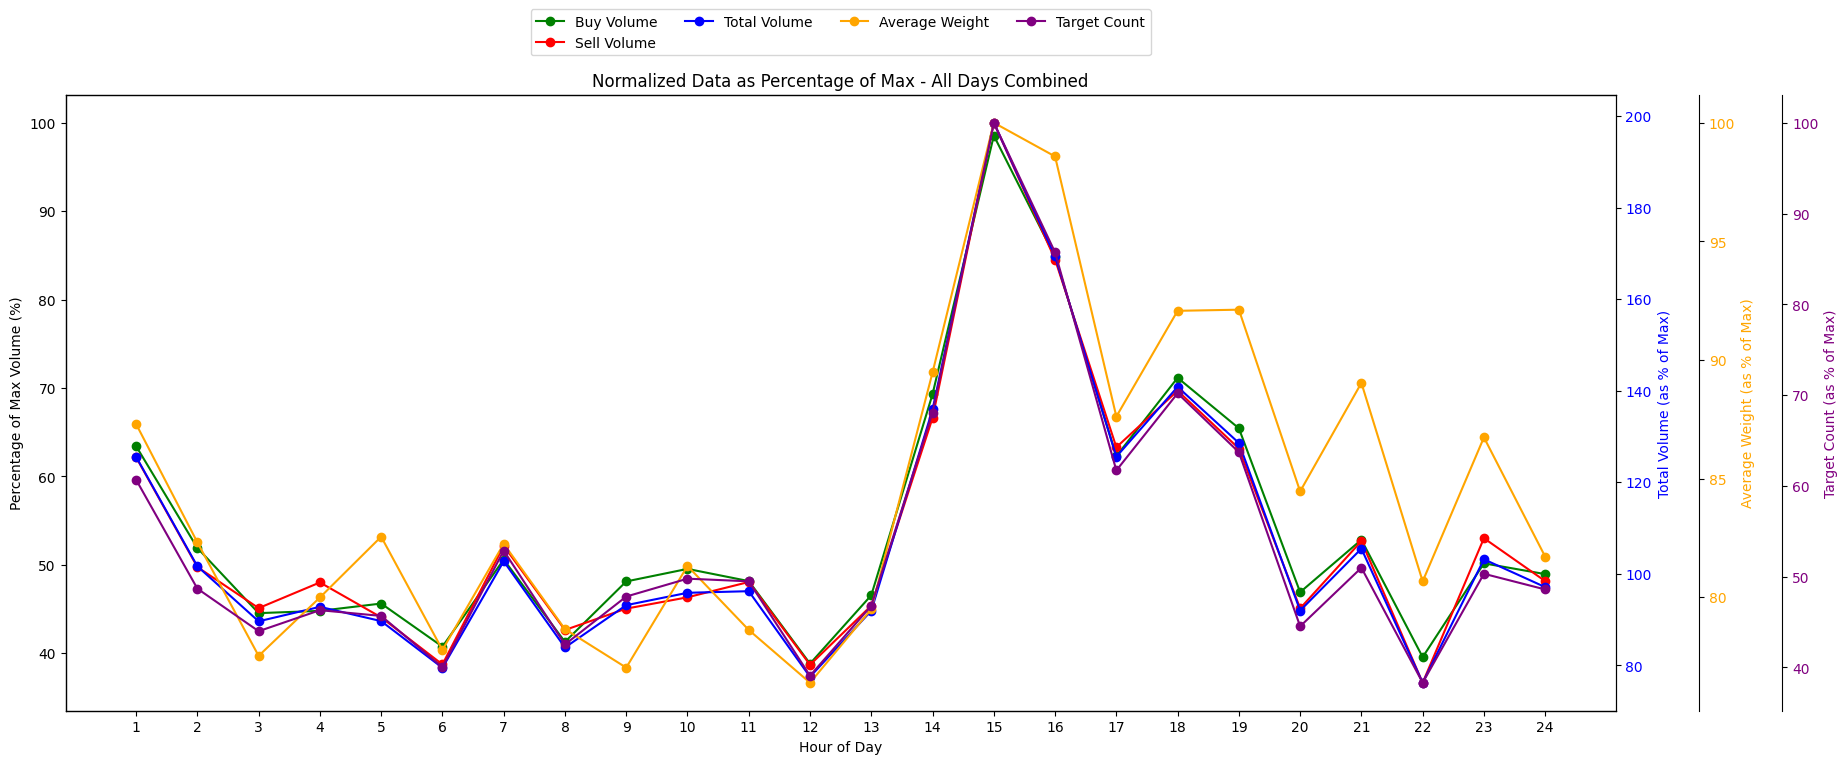

In [95]:
data = target_solusdt_full
data['timestamp_ns'] = pd.to_datetime(data.index, unit='ns')
data.set_index('timestamp_ns', inplace=True)
# Map side column values to categorical labels
data['side'] = data['side'].map({1: 'buy', -1: 'sell'})

# Map for day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a histogram for all 7 days combined
total_hourly_side_counts = data.groupby(data.index.hour)['side'].value_counts().unstack(fill_value=0)
total_hourly_average_weight = data.groupby(data.index.hour)['weight'].mean()
total_hourly_target_count = data[data['target'] == 1].groupby(data[data['target'] == 1].index.hour)['target'].count()

# Normalize all data to 100% of the maximum in the period
max_total_volume = total_hourly_side_counts.values.max()
total_hourly_side_counts_normalized = total_hourly_side_counts / max_total_volume * 100
total_hourly_average_weight_normalized = total_hourly_average_weight / total_hourly_average_weight.max() * 100
total_hourly_target_count_normalized = total_hourly_target_count / total_hourly_target_count.max() * 100

# Adjust x_positions for 1-based indexing
x_positions = np.arange(1, len(total_hourly_side_counts_normalized) + 1) * 1.5

# Plot normalized data for all days combined
fig, ax = plt.subplots(figsize=(20, 8))  # Increased figure size for better spacing

# Plot buys and sells as lines
ax.plot(x_positions, total_hourly_side_counts_normalized['buy'], color='green', marker='o', label="Buy Volume", zorder=3)
ax.plot(x_positions, total_hourly_side_counts_normalized['sell'], color='red', marker='o', label="Sell Volume", zorder=3)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Percentage of Max Volume (%)')

# Plot total volume as a line
ax2 = ax.twinx()
ax2.plot(x_positions, total_hourly_side_counts_normalized.sum(axis=1), color='blue', marker='o', label='Total Volume', zorder=4)
ax2.set_ylabel('Total Volume (as % of Max)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Plot average weight as a line
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(x_positions, total_hourly_average_weight_normalized, color='orange', marker='o', label='Average Weight', zorder=2)
ax3.set_ylabel('Average Weight (as % of Max)', color='orange')
ax3.tick_params(axis='y', labelcolor='orange')

# Plot target count as a line
ax4 = ax.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth axis
ax4.plot(x_positions, total_hourly_target_count_normalized, color='purple', marker='o', label='Target Count', zorder=1)
ax4.set_ylabel('Target Count (as % of Max)', color='purple')
ax4.tick_params(axis='y', labelcolor='purple')

# Combine legends and bring to the top
lines, labels = [], []
for ax_ in [ax, ax2, ax3, ax4]:
    for line, label in zip(ax_.get_legend_handles_labels()[0], ax_.get_legend_handles_labels()[1]):
        lines.append(line)
        labels.append(label)
ax.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

# Adjust x-axis ticks for better spacing
ax.set_xticks(x_positions)
ax.set_xticklabels(range(1, 25), rotation=0)  # Updated x-axis ticks to range 1-24

plt.title('Normalized Data as Percentage of Max - All Days Combined')
plt.show()

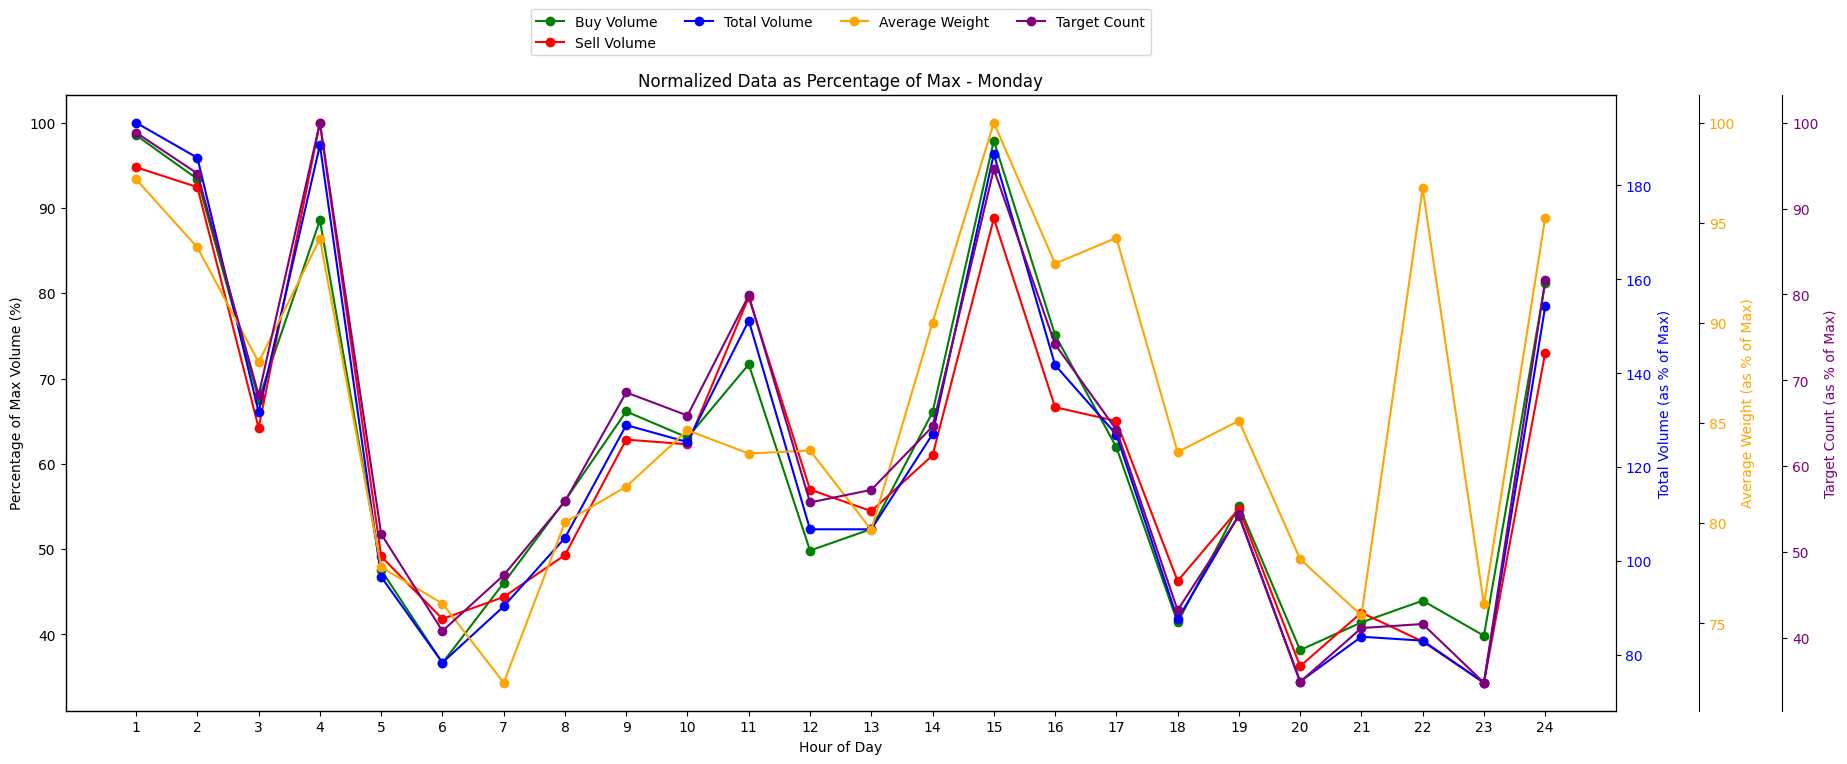

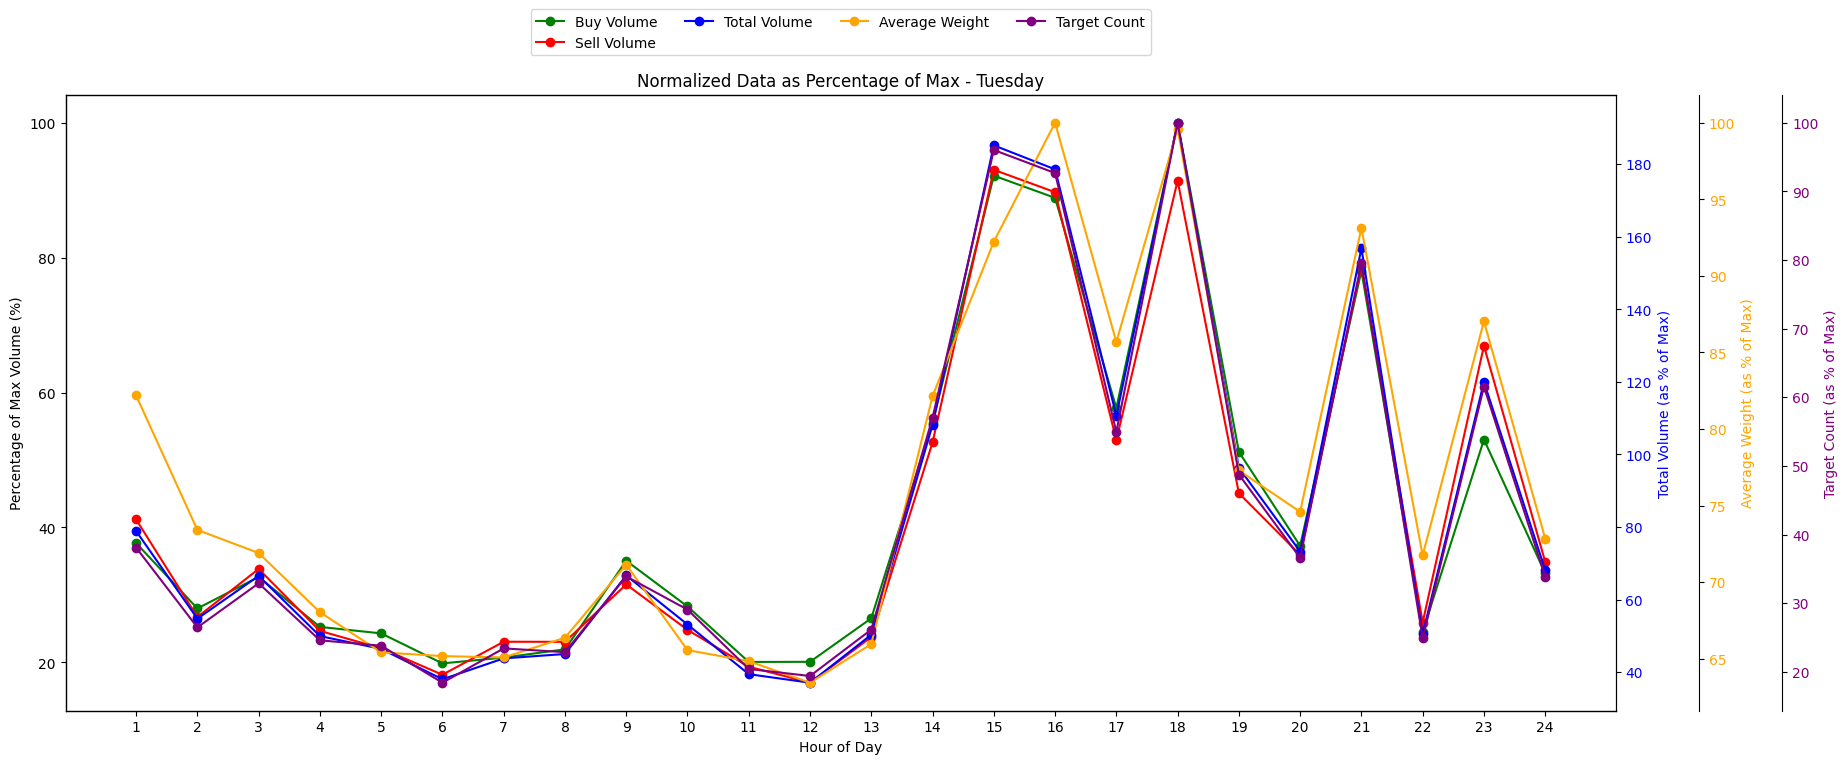

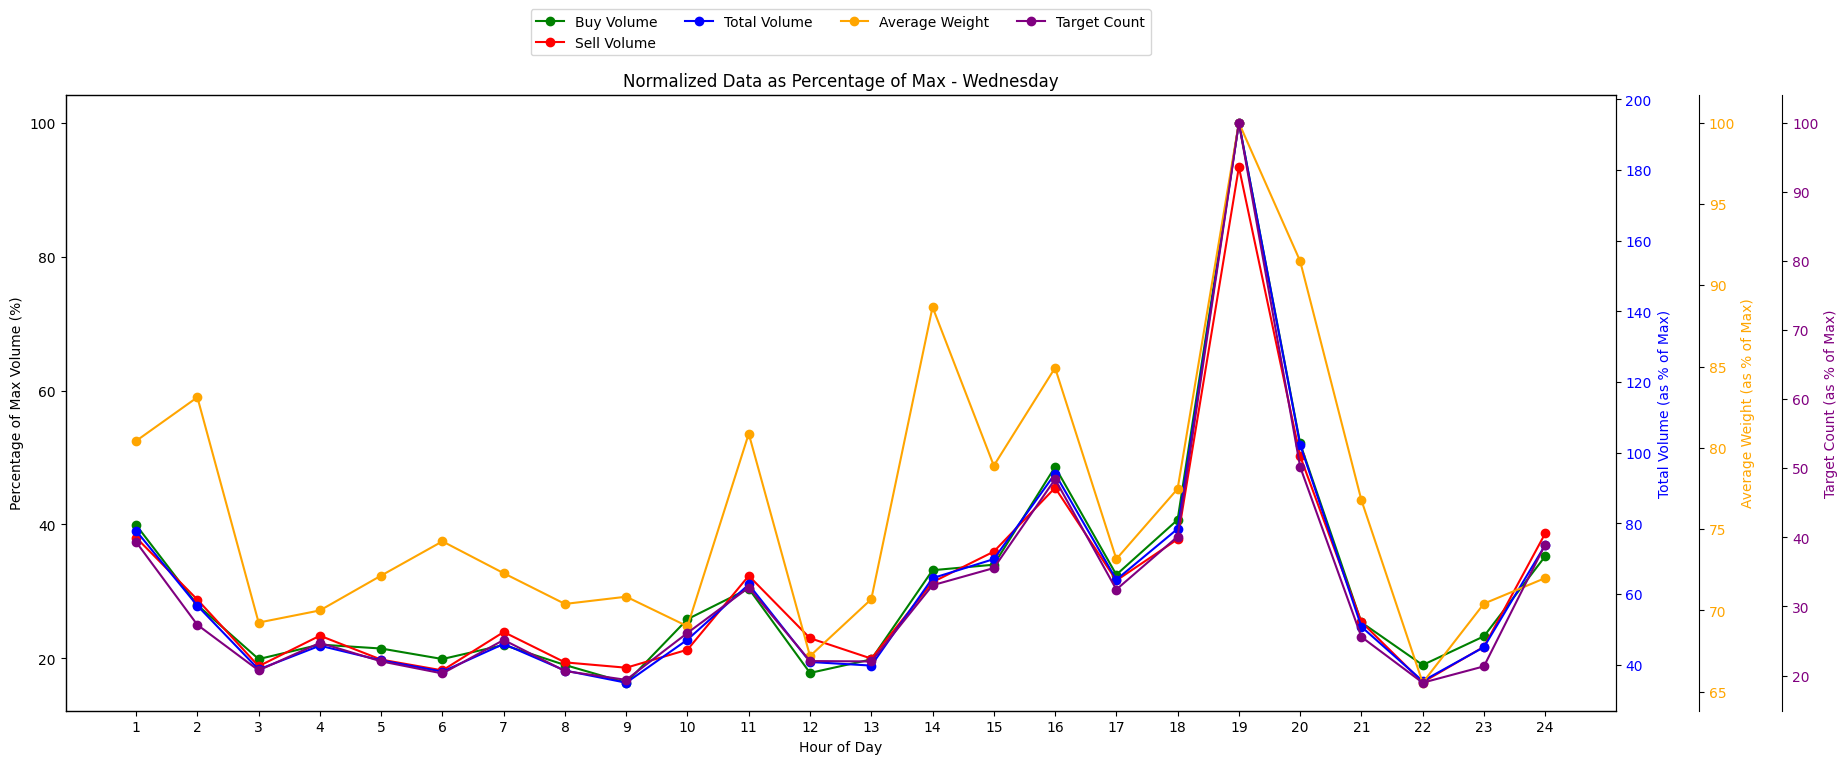

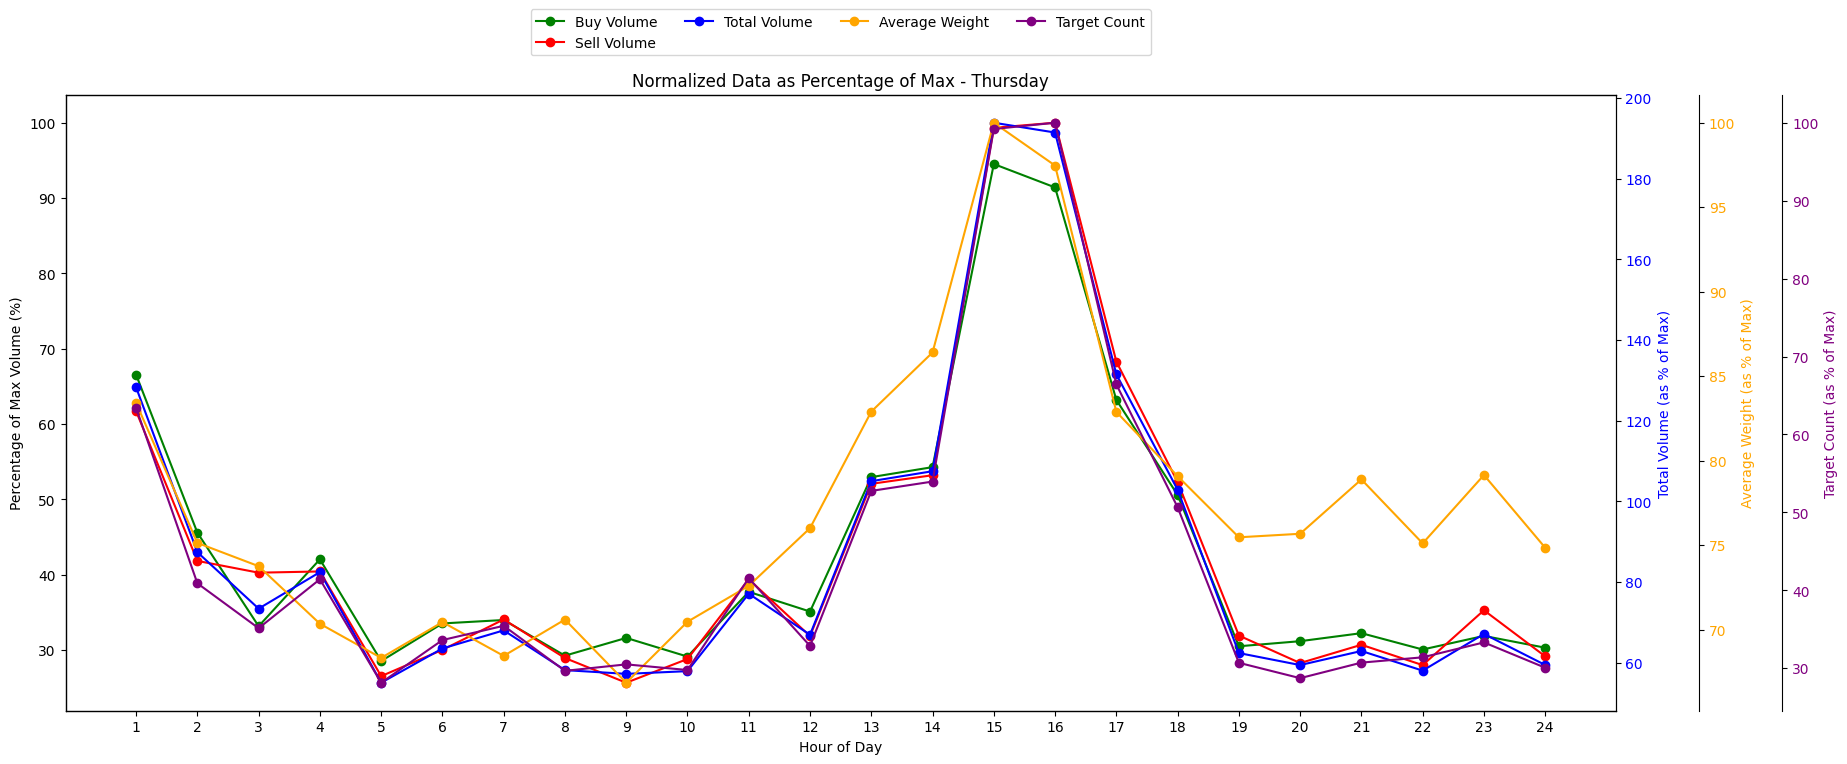

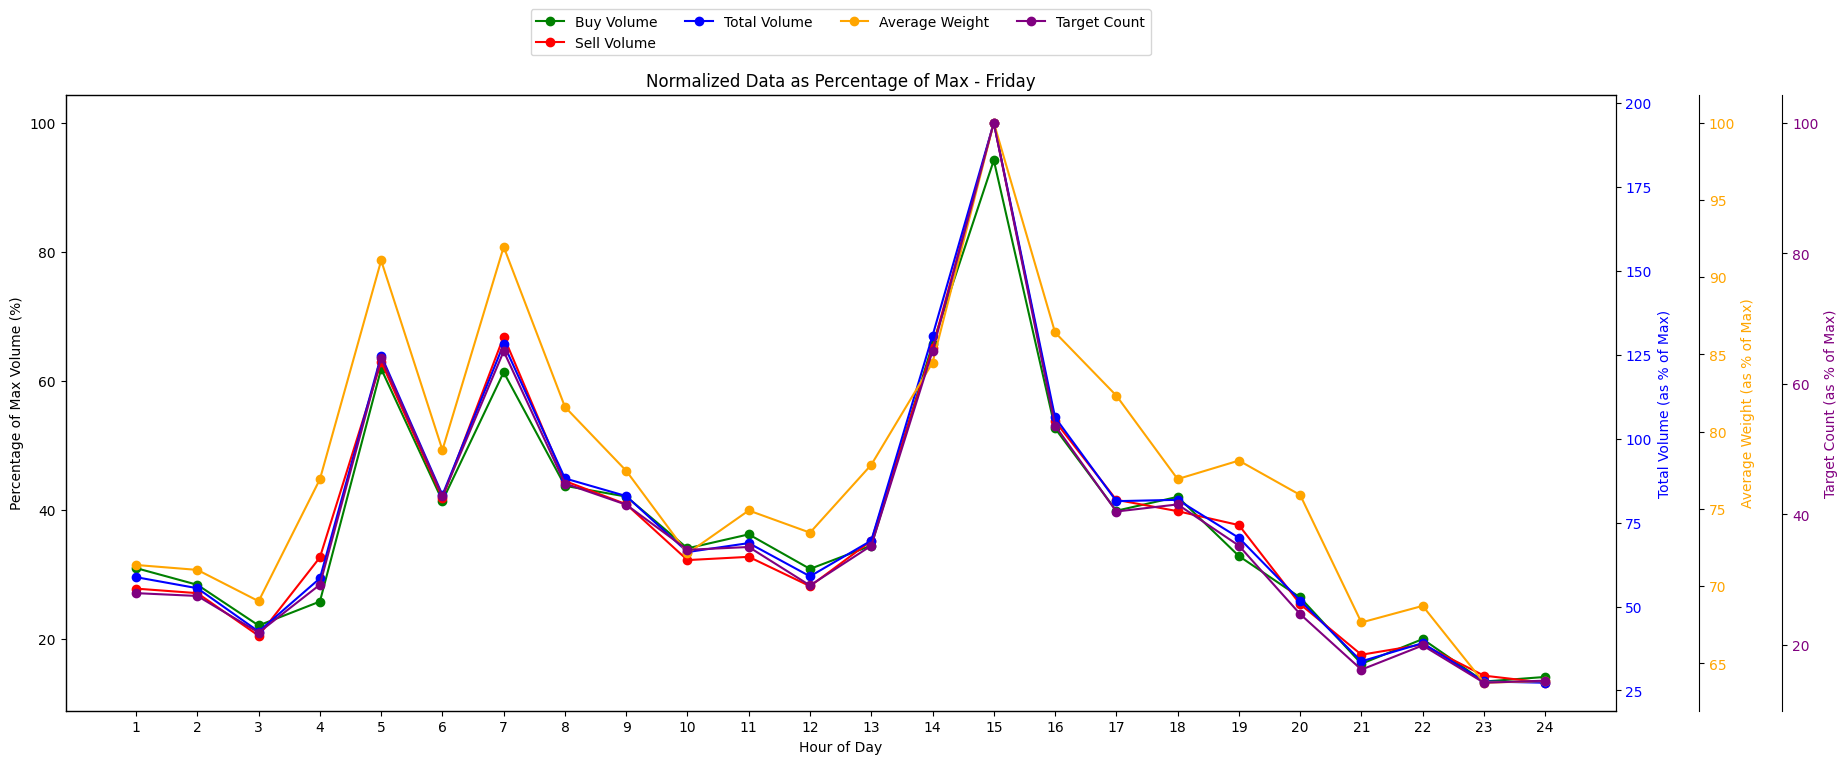

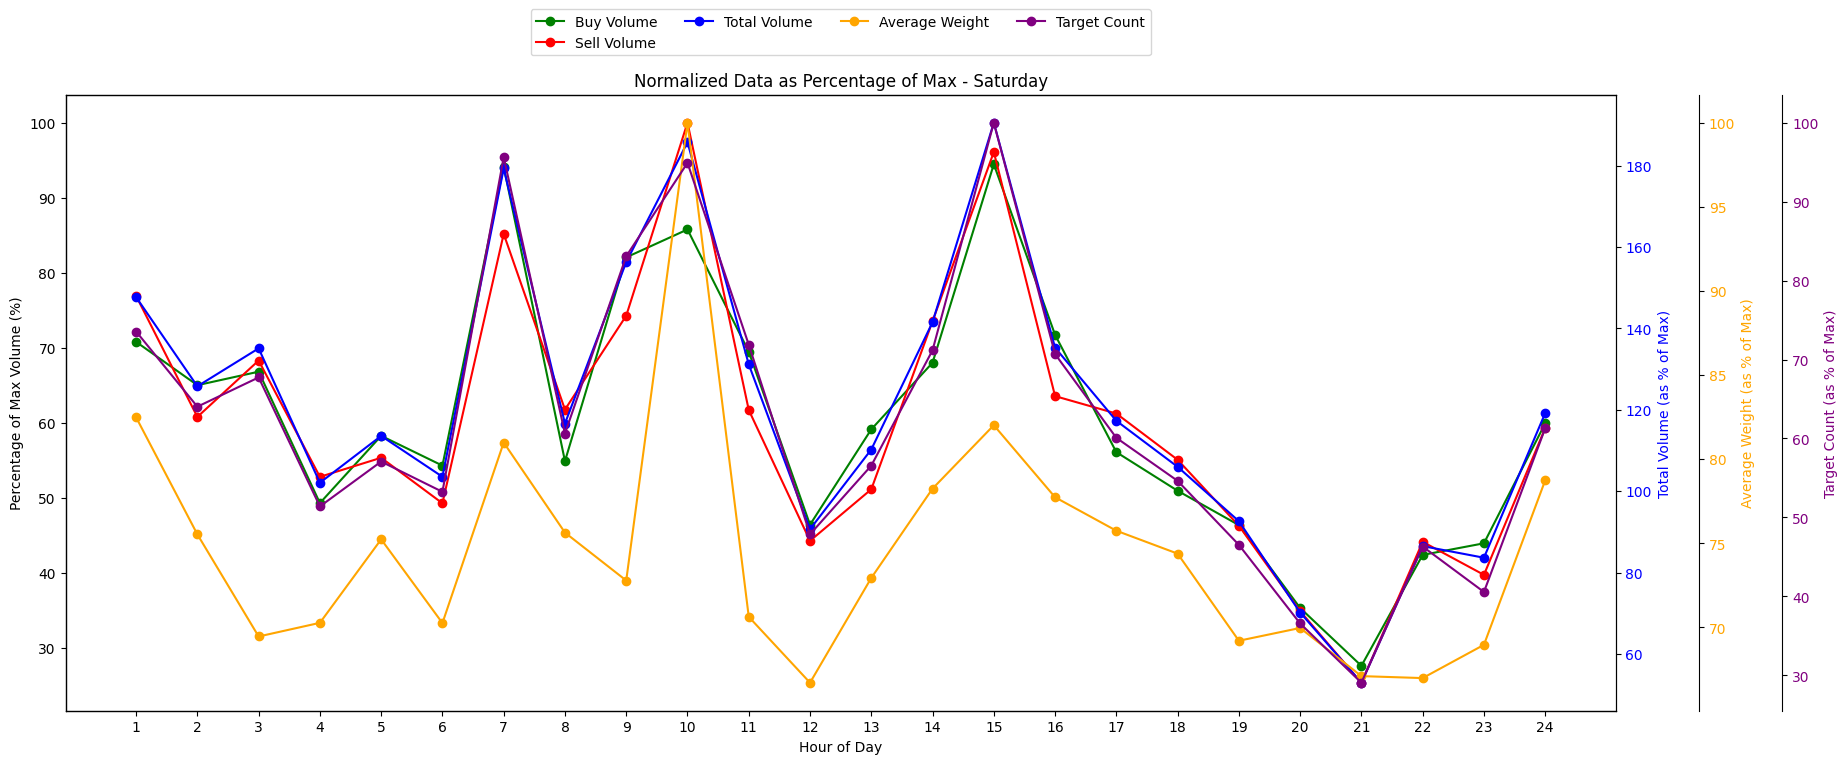

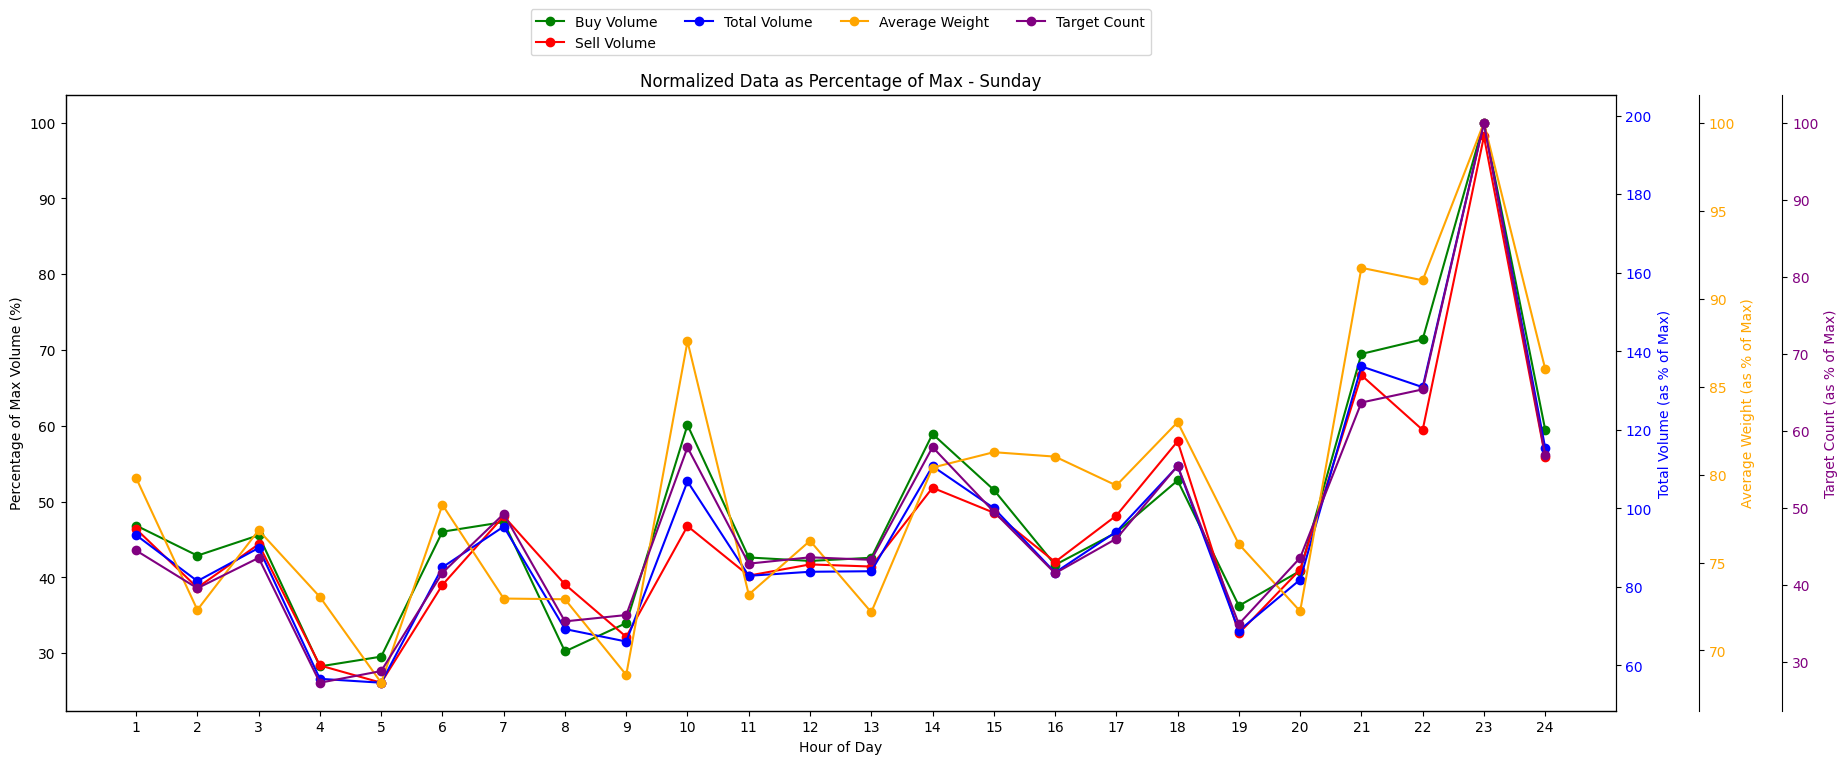

In [96]:
# Side distribution by hour for each day of the week
for day in range(7):
    daily_data = data[data.index.dayofweek == day]
    hourly_side_counts = daily_data.groupby(daily_data.index.hour)['side'].value_counts().unstack(fill_value=0)
    hourly_average_weight = daily_data.groupby(daily_data.index.hour)['weight'].mean()
    hourly_target_count = daily_data[daily_data['target'] == 1].groupby(daily_data[daily_data['target'] == 1].index.hour)['target'].count()

    # Normalize all data to 100% of the maximum in the period
    max_total_volume = hourly_side_counts.values.max()
    hourly_side_counts_normalized = hourly_side_counts / max_total_volume * 100
    hourly_average_weight_normalized = hourly_average_weight / hourly_average_weight.max() * 100
    hourly_target_count_normalized = hourly_target_count / hourly_target_count.max() * 100

    # Adjust x_positions for 1-based indexing
    x_positions = np.arange(1, len(hourly_side_counts_normalized) + 1) * 1.5

    # Plot normalized data
    fig, ax = plt.subplots(figsize=(20, 8))  # Increased figure size for better spacing

    # Plot buys and sells as lines
    ax.plot(x_positions, hourly_side_counts_normalized['buy'], color='green', marker='o', label="Buy Volume", zorder=3)
    ax.plot(x_positions, hourly_side_counts_normalized['sell'], color='red', marker='o', label="Sell Volume", zorder=3)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Percentage of Max Volume (%)')

    # Plot total volume as a line
    ax2 = ax.twinx()
    ax2.plot(x_positions, hourly_side_counts_normalized.sum(axis=1), color='blue', marker='o', label='Total Volume', zorder=4)
    ax2.set_ylabel('Total Volume (as % of Max)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Plot average weight as a line
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
    ax3.plot(x_positions, hourly_average_weight_normalized, color='orange', marker='o', label='Average Weight', zorder=2)
    ax3.set_ylabel('Average Weight (as % of Max)', color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')

    # Plot target count as a line
    ax4 = ax.twinx()
    ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth axis
    ax4.plot(x_positions, hourly_target_count_normalized, color='purple', marker='o', label='Target Count', zorder=1)
    ax4.set_ylabel('Target Count (as % of Max)', color='purple')
    ax4.tick_params(axis='y', labelcolor='purple')

    # Combine legends and bring to the top
    lines, labels = [], []
    for ax_ in [ax, ax2, ax3, ax4]:
        for line, label in zip(ax_.get_legend_handles_labels()[0], ax_.get_legend_handles_labels()[1]):
            lines.append(line)
            labels.append(label)
    ax.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

    # Adjust x-axis ticks for better spacing
    ax.set_xticks(x_positions)
    ax.set_xticklabels(range(1, 25), rotation=0)  # Updated x-axis ticks to range 1-24

    plt.title(f'Normalized Data as Percentage of Max - {day_names[day]}')
    plt.show()


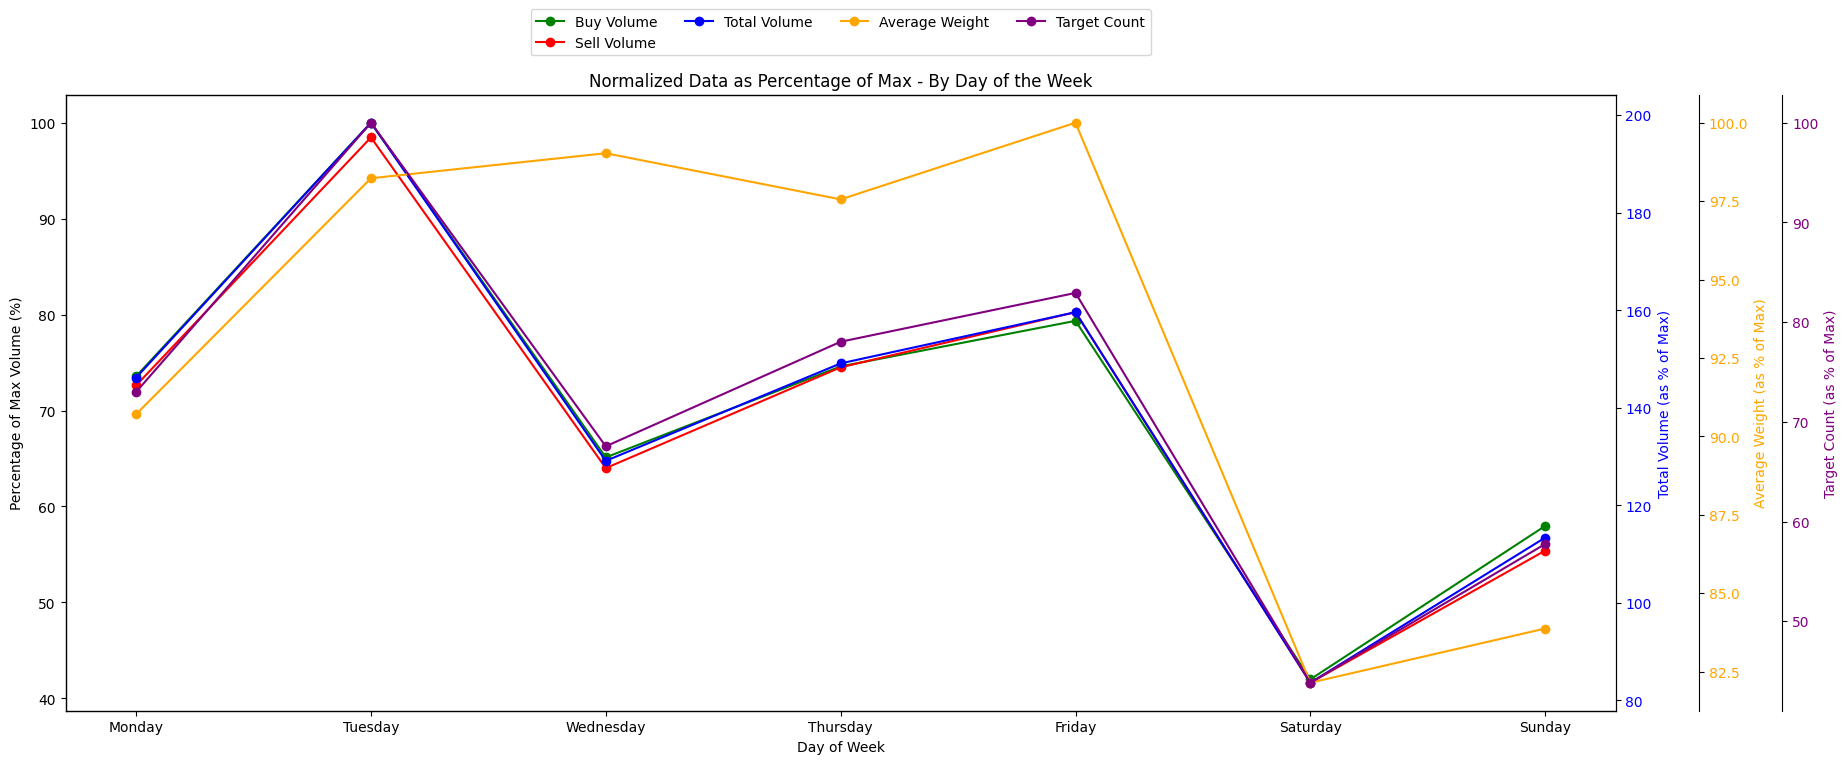

In [ ]:
# Create a histogram for all 7 days combined
total_daily_side_counts = data.groupby(data.index.dayofweek)['side'].value_counts().unstack(fill_value=0)
total_daily_average_weight = data.groupby(data.index.dayofweek)['weight'].mean()
total_daily_target_count = data[data['target'] == 1].groupby(data[data['target'] == 1].index.dayofweek)['target'].count()

# Normalize all data to 100% of the maximum in the period
max_total_volume = total_daily_side_counts.values.max()
total_daily_side_counts_normalized = total_daily_side_counts / max_total_volume * 100
total_daily_average_weight_normalized = total_daily_average_weight / total_daily_average_weight.max() * 100
total_daily_target_count_normalized = total_daily_target_count / total_daily_target_count.max() * 100

# Adjust x_positions for days
x_positions = np.arange(len(day_names)) * 1.5

# Plot normalized data for all days combined
fig, ax = plt.subplots(figsize=(20, 8))  # Increased figure size for better spacing

# Plot buys and sells as lines
ax.plot(x_positions, total_daily_side_counts_normalized['buy'], color='green', marker='o', label="Buy Volume", zorder=3)
ax.plot(x_positions, total_daily_side_counts_normalized['sell'], color='red', marker='o', label="Sell Volume", zorder=3)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Percentage of Max Volume (%)')

# Plot total volume as a line
ax2 = ax.twinx()
ax2.plot(x_positions, total_daily_side_counts_normalized.sum(axis=1), color='blue', marker='o', label='Total Volume', zorder=4)
ax2.set_ylabel('Total Volume (as % of Max)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Plot average weight as a line
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(x_positions, total_daily_average_weight_normalized, color='orange', marker='o', label='Average Weight', zorder=2)
ax3.set_ylabel('Average Weight (as % of Max)', color='orange')
ax3.tick_params(axis='y', labelcolor='orange')

# Plot target count as a line
ax4 = ax.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth axis
ax4.plot(x_positions, total_daily_target_count_normalized, color='purple', marker='o', label='Target Count', zorder=1)
ax4.set_ylabel('Target Count (as % of Max)', color='purple')
ax4.tick_params(axis='y', labelcolor='purple')

# Combine legends and bring to the top
lines, labels = [], []
for ax_ in [ax, ax2, ax3, ax4]:
    for line, label in zip(ax_.get_legend_handles_labels()[0], ax_.get_legend_handles_labels()[1]):
        lines.append(line)
        labels.append(label)
ax.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

# Adjust x-axis ticks for better spacing
ax.set_xticks(x_positions)
ax.set_xticklabels(day_names, rotation=0)  # Updated x-axis ticks to day names

plt.title('Normalized Data as Percentage of Max - By Day of the Week')
plt.show()

# Let's add columns to df

In [ ]:
df = target_solusdt_full
# data.index = pd.to_datetime(data.index, unit='ns')
df = df.reset_index()
df.rename(columns={"target": "participation_in_deal"}, inplace=True)
df['participation_in_deal'] = df['participation_in_deal'].map({0: False, 1: True})

# Map the values in 'side'
df['side'] = df['side'].map({1: 'buy', -1: 'sell'})
df['trade_value']= df['amount']*df['price']

df

timestamp_ns  side       price  amount    weight  \
0        1726617603492082000   buy  131.466995     7.0  0.397396   
1        1726617603512695000   buy  131.466995     1.0  0.150202   
2        1726617603512698000   buy  131.466003     2.0  0.207696   
3        1726617603543949000  sell  131.460007     8.0  0.433219   
4        1726617603710144000   buy  131.459000     1.0  0.120686   
...                      ...   ...         ...     ...       ...   
9163342  1727827199560359000   buy  145.072998     3.0  0.021153   
9163343  1727827199560366000   buy  145.072006     1.0  0.029028   
9163344  1727827199560372000   buy  145.072006     3.0  0.050278   
9163345  1727827199721740000   buy  145.070999     9.0  0.129024   
9163346  1727827199762003000  sell  145.072006   127.0  0.999216   

         participation_in_deal   trade_value  
0                        False    920.268982  
1                        False    131.466995  
2                        False    262.932007  
3                         True   1051.680054  
4                        False    131.459000  
...                        ...           ...  
9163342                  False    435.218994  
9163343                   True    145.072006  
9163344                   True    435.216003  
9163345                   True   1305.639038  
9163346                   True  18424.144531  

[9163347 rows x 7 columns]

In [83]:
def categorize_price_change_boolean(price_changes):
    return {
        '<1%': price_changes < 1,
        '1-5%': (price_changes >= 1) & (price_changes < 5),
        '5-10%': (price_changes >= 5) & (price_changes < 10),
        '10-15%': (price_changes >= 10) & (price_changes < 15),
        '15-20%': (price_changes >= 15) & (price_changes < 20),
        '>20%': price_changes >= 20,
    }

# Apply the boolean mapping for each range without adding calculations to the table
price_changes_last_row = df['price'].pct_change(periods=1).abs() * 100
price_changes_last_5 = df['price'].pct_change(periods=5).abs() * 100
price_changes_last_10 = df['price'].pct_change(periods=10).abs() * 100
price_changes_last_100 = df['price'].pct_change(periods=100).abs() * 100

# Map to boolean categories
price_change_last_row_boolean = categorize_price_change_boolean(price_changes_last_row)
price_change_last_5_boolean = categorize_price_change_boolean(price_changes_last_5)
price_change_last_10_boolean = categorize_price_change_boolean(price_changes_last_10)
price_change_last_100_boolean = categorize_price_change_boolean(price_changes_last_100)


In [85]:
price_change_last_100_boolean

{'<1%': 0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 9163342     True
 9163343     True
 9163344     True
 9163345     True
 9163346     True
 Name: price, Length: 9163347, dtype: bool,
 '1-5%': 0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 9163342    False
 9163343    False
 9163344    False
 9163345    False
 9163346    False
 Name: price, Length: 9163347, dtype: bool,
 '5-10%': 0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 9163342    False
 9163343    False
 9163344    False
 9163345    False
 9163346    False
 Name: price, Length: 9163347, dtype: bool,
 '10-15%': 0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 9163342    False
 9163343    False
 9163344    False
 9163345    False
 9163346    False
 Name: price, Length: 9163347, dtype: bool

In [74]:

# Create regression target: derivative of cumulative total volume
data['trade_value']= data['amount']*data['price']
data['trade_value_cumulative'] = data['trade_value'].cumsum()
# data['volume_difference'] = data['trade_value_cumulative'].diff()


# Convert timestamps to seconds
data['timestamp_seconds'] = data["timestamp_ns"] / 1e9  # Convert to seconds

# Identify rows with duplicate timestamps
duplicate_timestamps = data['timestamp_seconds'].duplicated(keep='first')

# Initialize trade_value_derivative with NaN
data['trade_value_derivative'] = np.nan

# Calculate time differences
time_intervals = np.diff(data['timestamp_seconds'], prepend=data['timestamp_seconds'][0])

# Calculate derivative where timestamps are not duplicate
non_duplicate_indices = ~duplicate_timestamps
data.loc[non_duplicate_indices, 'trade_value_derivative'] = np.gradient(
    data.loc[non_duplicate_indices, 'trade_value_cumulative'],
    data.loc[non_duplicate_indices, 'timestamp_seconds']
)

# Fill derivatives for duplicate timestamps with the previous value
data['trade_value_derivative'].fillna(method='ffill', inplace=True)

/tmp/ipykernel_9779/4087519487.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['trade_value_derivative'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_9779/4087519487.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['trade_value_derivative'].fillna(method='ffill', inplace=True)


In [75]:
data

timestamp_ns  side       price  amount    weight  target  \
0        1726617603492082000     1  131.466995     7.0  0.397396       0   
1        1726617603512695000     1  131.466995     1.0  0.150202       0   
2        1726617603512698000     1  131.466003     2.0  0.207696       0   
3        1726617603543949000    -1  131.460007     8.0  0.433219       1   
4        1726617603710144000     1  131.459000     1.0  0.120686       0   
...                      ...   ...         ...     ...       ...     ...   
9163342  1727827199560359000     1  145.072998     3.0  0.021153       0   
9163343  1727827199560366000     1  145.072006     1.0  0.029028       1   
9163344  1727827199560372000     1  145.072006     3.0  0.050278       1   
9163345  1727827199721740000     1  145.070999     9.0  0.129024       1   
9163346  1727827199762003000    -1  145.072006   127.0  0.999216       1   

          trade_value  trade_value_cumulative  timestamp_seconds  \
0          920.268982            9.202690e+02       1.726618e+09   
1          131.466995            1.051736e+03       1.726618e+09   
2          262.932007            1.314668e+03       1.726618e+09   
3         1051.680054            2.366348e+03       1.726618e+09   
4          131.459000            2.497807e+03       1.726618e+09   
...               ...                     ...                ...   
9163342    435.218994            3.384703e+10       1.727827e+09   
9163343    145.072006            3.384703e+10       1.727827e+09   
9163344    435.216003            3.384703e+10       1.727827e+09   
9163345   1305.639038            3.384703e+10       1.727827e+09   
9163346  18424.144531            3.384705e+10       1.727827e+09   

         trade_value_derivative  
0                  6.377808e+03  
1                  8.481930e+07  
2                  8.482365e+07  
3                  2.845151e+04  
4                  3.750003e+06  
...                         ...  
9163342            5.000000e-01  
9163343            0.000000e+00  
9163344           -5.328662e-01  
9163345            3.689106e+05  
9163346            4.577908e+05  

[9163347 rows x 10 columns]

In [76]:
data

timestamp_ns  side       price  amount    weight  target  \
0        1726617603492082000     1  131.466995     7.0  0.397396       0   
1        1726617603512695000     1  131.466995     1.0  0.150202       0   
2        1726617603512698000     1  131.466003     2.0  0.207696       0   
3        1726617603543949000    -1  131.460007     8.0  0.433219       1   
4        1726617603710144000     1  131.459000     1.0  0.120686       0   
...                      ...   ...         ...     ...       ...     ...   
9163342  1727827199560359000     1  145.072998     3.0  0.021153       0   
9163343  1727827199560366000     1  145.072006     1.0  0.029028       1   
9163344  1727827199560372000     1  145.072006     3.0  0.050278       1   
9163345  1727827199721740000     1  145.070999     9.0  0.129024       1   
9163346  1727827199762003000    -1  145.072006   127.0  0.999216       1   

          trade_value  trade_value_cumulative  timestamp_seconds  \
0          920.268982            9.202690e+02       1.726618e+09   
1          131.466995            1.051736e+03       1.726618e+09   
2          262.932007            1.314668e+03       1.726618e+09   
3         1051.680054            2.366348e+03       1.726618e+09   
4          131.459000            2.497807e+03       1.726618e+09   
...               ...                     ...                ...   
9163342    435.218994            3.384703e+10       1.727827e+09   
9163343    145.072006            3.384703e+10       1.727827e+09   
9163344    435.216003            3.384703e+10       1.727827e+09   
9163345   1305.639038            3.384703e+10       1.727827e+09   
9163346  18424.144531            3.384705e+10       1.727827e+09   

         trade_value_derivative  
0                  6.377808e+03  
1                  8.481930e+07  
2                  8.482365e+07  
3                  2.845151e+04  
4                  3.750003e+06  
...                         ...  
9163342            5.000000e-01  
9163343            0.000000e+00  
9163344           -5.328662e-01  
9163345            3.689106e+05  
9163346            4.577908e+05  

[9163347 rows x 10 columns]

In [62]:
all_ones = pd.Series(1, index=data.index, name="all_ones")
intersection_with_ones = (data['regression_target'] == all_ones).sum()

# Calculate the total number of rows
total_rows = len(data)

# Calculate the percentage intersection
percentage_intersection_with_ones = (intersection_with_ones / total_rows) * 100

# Print the result
print(f"Percentage Intersection with All Ones: {percentage_intersection_with_ones:.2f}%")

Percentage Intersection with All Ones: 46.17%


In [61]:
intersection = (data['target'] == data['regression_target']).sum()

# Calculate the total number of rows
total = len(data)

# Calculate the percentage intersection
percentage_intersection = (intersection / total) * 100

# Print the result
print(f"Percentage Intersection: {percentage_intersection:.2f}%")

Percentage Intersection: 52.37%


In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

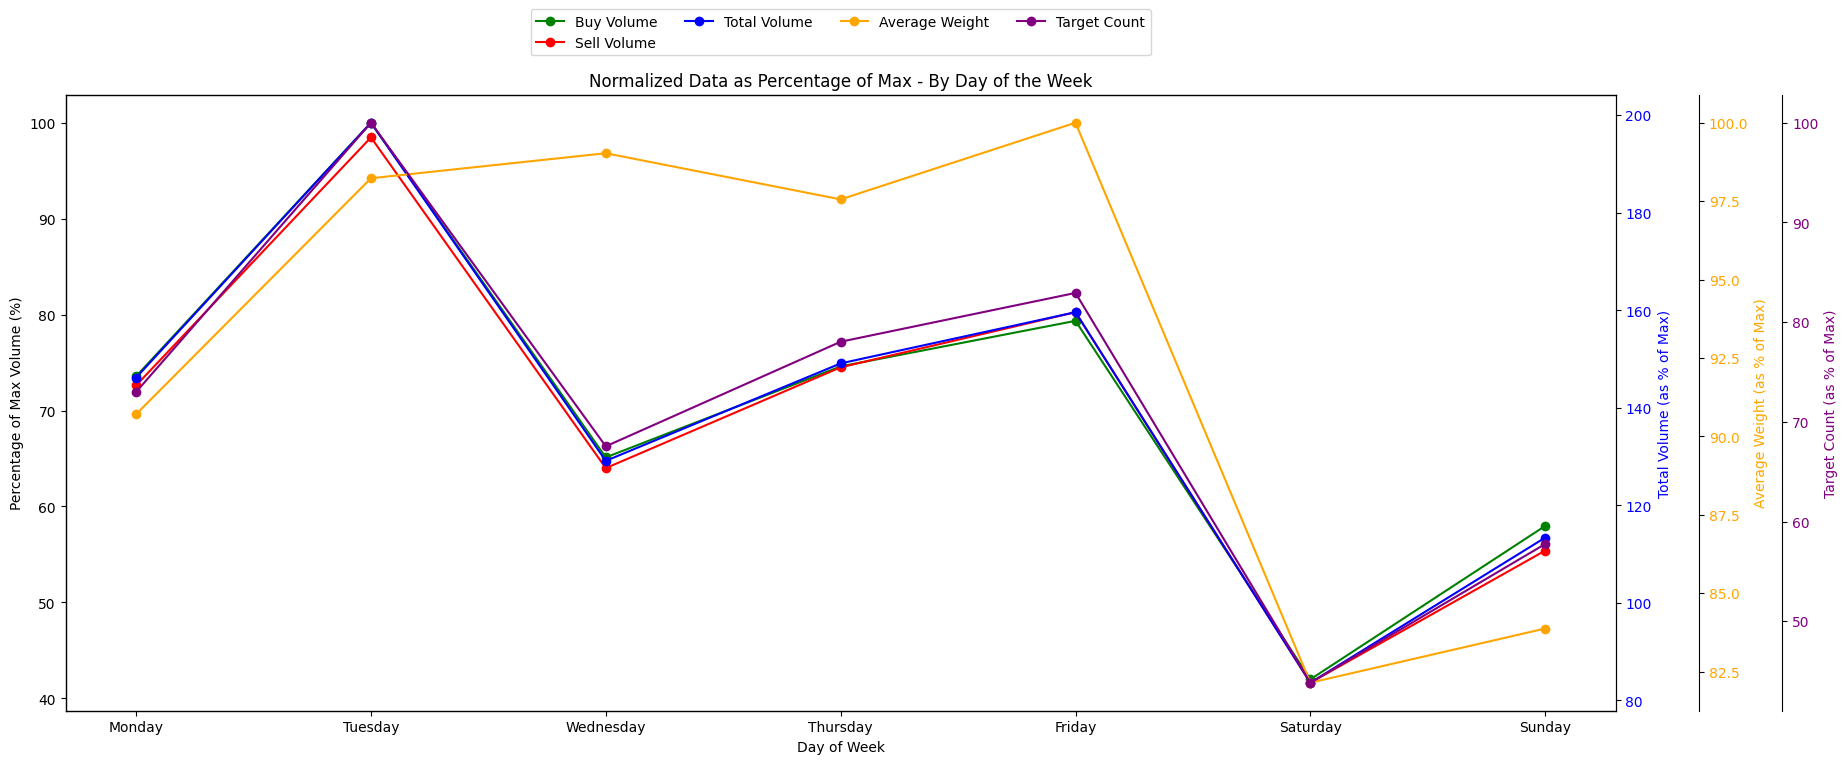

In [ ]:
# Map for day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a histogram for all 7 days combined
total_hourly_side_counts = data.groupby(data.index.hour)['side'].value_counts().unstack(fill_value=0)
total_hourly_average_weight = data.groupby(data.index.hour)['weight'].mean()
total_hourly_target_count = data[data['target'] == 1].groupby(data[data['target'] == 1].index.hour)['target'].count()

# Normalize all data to 100% of the maximum in the period
max_total_volume = total_hourly_side_counts.values.max()
total_hourly_side_counts_normalized = total_hourly_side_counts / max_total_volume * 100
total_hourly_average_weight_normalized = total_hourly_average_weight / total_hourly_average_weight.max() * 100
total_hourly_target_count_normalized = total_hourly_target_count / total_hourly_target_count.max() * 100

# Adjust x_positions for 1-based indexing
x_positions = np.arange(1, len(total_hourly_side_counts_normalized) + 1) * 1.5

# Plot normalized data for all days combined
fig, ax = plt.subplots(figsize=(20, 8))  # Increased figure size for better spacing

# Plot buys and sells as lines
ax.plot(x_positions, total_hourly_side_counts_normalized['buy'], color='green', marker='o', label="Buy Volume", zorder=3)
ax.plot(x_positions, total_hourly_side_counts_normalized['sell'], color='red', marker='o', label="Sell Volume", zorder=3)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Percentage of Max Volume (%)')

# Plot total volume as a line
ax2 = ax.twinx()
ax2.plot(x_positions, total_hourly_side_counts_normalized.sum(axis=1), color='blue', marker='o', label='Total Volume', zorder=4)
ax2.set_ylabel('Total Volume (as % of Max)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Plot average weight as a line
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(x_positions, total_hourly_average_weight_normalized, color='orange', marker='o', label='Average Weight', zorder=2)
ax3.set_ylabel('Average Weight (as % of Max)', color='orange')
ax3.tick_params(axis='y', labelcolor='orange')

# Plot target count as a line
ax4 = ax.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth axis
ax4.plot(x_positions, total_hourly_target_count_normalized, color='purple', marker='o', label='Target Count', zorder=1)
ax4.set_ylabel('Target Count (as % of Max)', color='purple')
ax4.tick_params(axis='y', labelcolor='purple')

# Plot volume derivative as a line
ax.plot(x_positions, data.groupby(data.index.hour)['volume_derivative'].mean(), color='cyan', linestyle='--', marker='o', label='Volume Derivative', zorder=5)

# Combine legends and bring to the top
lines, labels = [], []
for ax_ in [ax, ax2, ax3, ax4]:
    for line, label in zip(ax_.get_legend_handles_labels()[0], ax_.get_legend_handles_labels()[1]):
        lines.append(line)
        labels.append(label)
ax.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

# Adjust x-axis ticks for better spacing
ax.set_xticks(x_positions)
ax.set_xticklabels(range(1, 25), rotation=0)  # Updated x-axis ticks to range 1-24

plt.title('Normalized Data as Percentage of Max - All Days Combined')
plt.show()


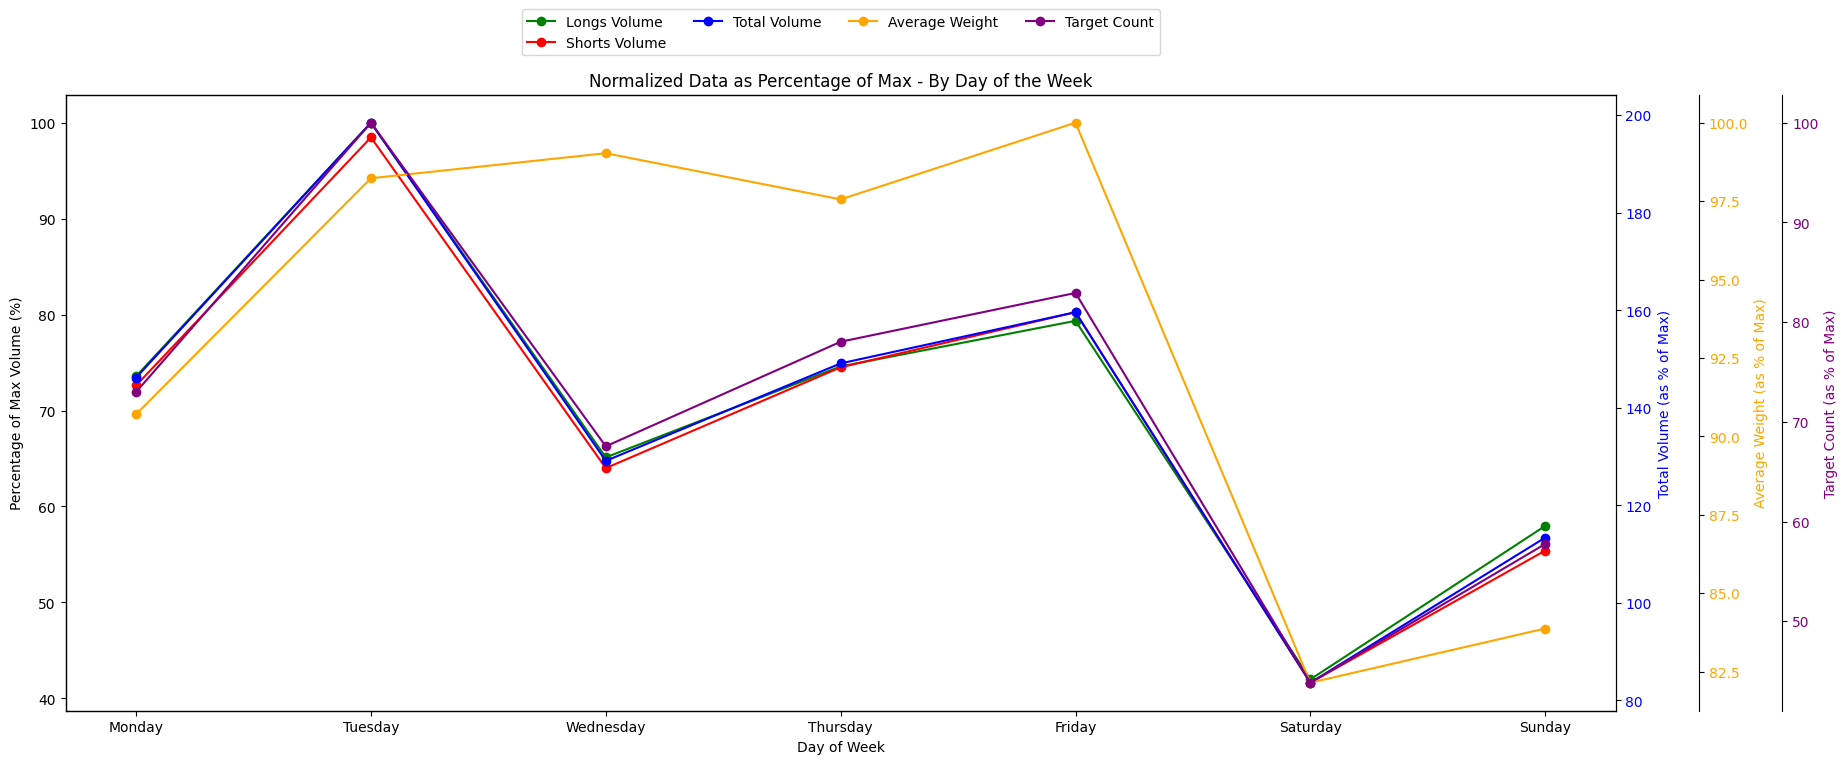

In [ ]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Aggregate data by day of the week
daily_side_counts = data.groupby(data.index.dayofweek)['side'].value_counts().unstack(fill_value=0)
daily_average_weight = data.groupby(data.index.dayofweek)['weight'].mean()
daily_target_count = data[data['target'] == 1].groupby(data[data['target'] == 1].index.dayofweek)['target'].count()

# Normalize all data to 100% of the maximum in the period
daily_side_counts_normalized = daily_side_counts / daily_side_counts.values.max() * 100
daily_average_weight_normalized = daily_average_weight / daily_average_weight.max() * 100
daily_target_count_normalized = daily_target_count / daily_target_count.max() * 100

# Adjust x_positions for days
x_positions = np.arange(len(day_names)) * 1.5

# Plot normalized data by day of the week
fig, ax = plt.subplots(figsize=(20, 8))

# Plot longs and shorts as lines
ax.plot(x_positions, daily_side_counts_normalized[1], color='green', marker='o', label="Longs Volume", zorder=3)
ax.plot(x_positions, daily_side_counts_normalized[-1], color='red', marker='o', label="Shorts Volume", zorder=3)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Percentage of Max Volume (%)')

# Plot total volume as a line
ax2 = ax.twinx()
ax2.plot(x_positions, daily_side_counts_normalized.sum(axis=1), color='blue', marker='o', label='Total Volume', zorder=4)
ax2.set_ylabel('Total Volume (as % of Max)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Plot average weight as a line
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(x_positions, daily_average_weight_normalized, color='orange', marker='o', label='Average Weight', zorder=2)
ax3.set_ylabel('Average Weight (as % of Max)', color='orange')
ax3.tick_params(axis='y', labelcolor='orange')

# Plot target count as a line
ax4 = ax.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth axis
ax4.plot(x_positions, daily_target_count_normalized, color='purple', marker='o', label='Target Count', zorder=1)
ax4.set_ylabel('Target Count (as % of Max)', color='purple')
ax4.tick_params(axis='y', labelcolor='purple')

# Combine legends and bring to the top
lines, labels = [], []
for ax_ in [ax, ax2, ax3, ax4]:
    for line, label in zip(ax_.get_legend_handles_labels()[0], ax_.get_legend_handles_labels()[1]):
        lines.append(line)
        labels.append(label)
ax.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

# Adjust x-axis ticks for better spacing
ax.set_xticks(x_positions)
ax.set_xticklabels(day_names, rotation=0)

plt.title('Normalized Data as Percentage of Max - By Day of the Week')
plt.show()


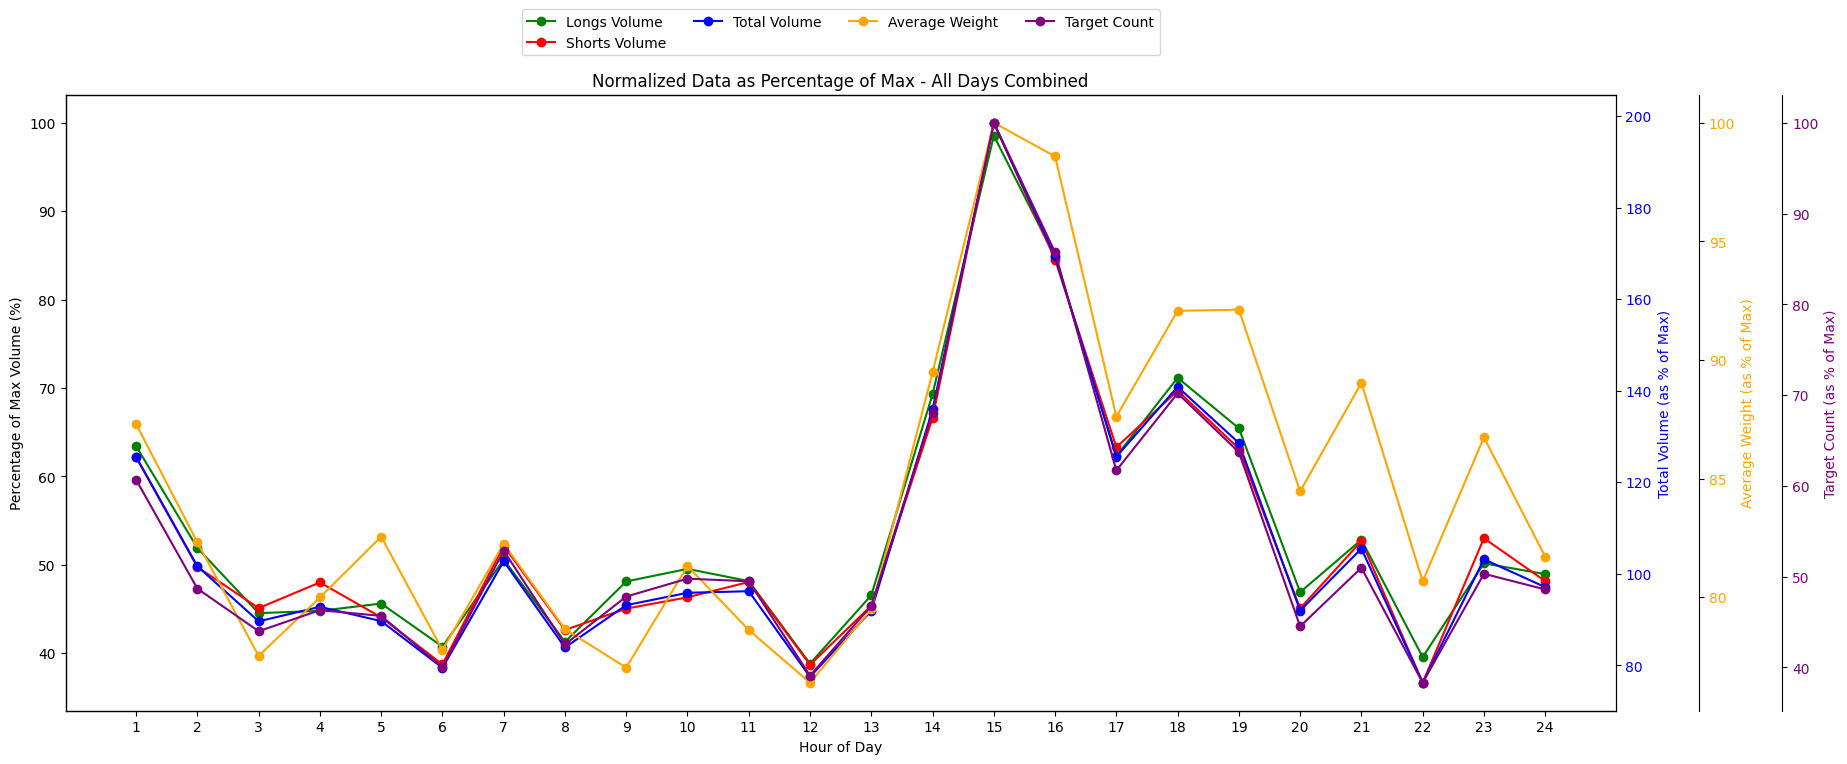

In [ ]:
# Create a histogram for all 7 days combined
total_hourly_side_counts = data.groupby(data.index.hour)['side'].value_counts().unstack(fill_value=0)
total_hourly_average_weight = data.groupby(data.index.hour)['weight'].mean()
total_hourly_target_count = data[data['target'] == 1].groupby(data[data['target'] == 1].index.hour)['target'].count()

# Normalize all data to 100% of the maximum in the period
max_total_volume = total_hourly_side_counts.values.max()
total_hourly_side_counts_normalized = total_hourly_side_counts / max_total_volume * 100
total_hourly_average_weight_normalized = total_hourly_average_weight / total_hourly_average_weight.max() * 100
total_hourly_target_count_normalized = total_hourly_target_count / total_hourly_target_count.max() * 100

# Adjust x_positions for 1-based indexing
x_positions = np.arange(1, len(total_hourly_side_counts_normalized) + 1) * 1.5

# Plot normalized data for all days combined
fig, ax = plt.subplots(figsize=(20, 8))  # Increased figure size for better spacing

# Plot longs and shorts as lines
ax.plot(x_positions, total_hourly_side_counts_normalized[1], color='green', marker='o', label="Longs Volume", zorder=3)
ax.plot(x_positions, total_hourly_side_counts_normalized[-1], color='red', marker='o', label="Shorts Volume", zorder=3)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Percentage of Max Volume (%)')

# Plot total volume as a line
ax2 = ax.twinx()
ax2.plot(x_positions, total_hourly_side_counts_normalized.sum(axis=1), color='blue', marker='o', label='Total Volume', zorder=4)
ax2.set_ylabel('Total Volume (as % of Max)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Plot average weight as a line
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(x_positions, total_hourly_average_weight_normalized, color='orange', marker='o', label='Average Weight', zorder=2)
ax3.set_ylabel('Average Weight (as % of Max)', color='orange')
ax3.tick_params(axis='y', labelcolor='orange')

# Plot target count as a line
ax4 = ax.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth axis
ax4.plot(x_positions, total_hourly_target_count_normalized, color='purple', marker='o', label='Target Count', zorder=1)
ax4.set_ylabel('Target Count (as % of Max)', color='purple')
ax4.tick_params(axis='y', labelcolor='purple')

# Combine legends and bring to the top
lines, labels = [], []
for ax_ in [ax, ax2, ax3, ax4]:
    for line, label in zip(ax_.get_legend_handles_labels()[0], ax_.get_legend_handles_labels()[1]):
        lines.append(line)
        labels.append(label)
ax.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

# Adjust x-axis ticks for better spacing
ax.set_xticks(x_positions)
ax.set_xticklabels(range(1, 25), rotation=0)  # Updated x-axis ticks to range 1-24

plt.title('Normalized Data as Percentage of Max - All Days Combined')
plt.show()

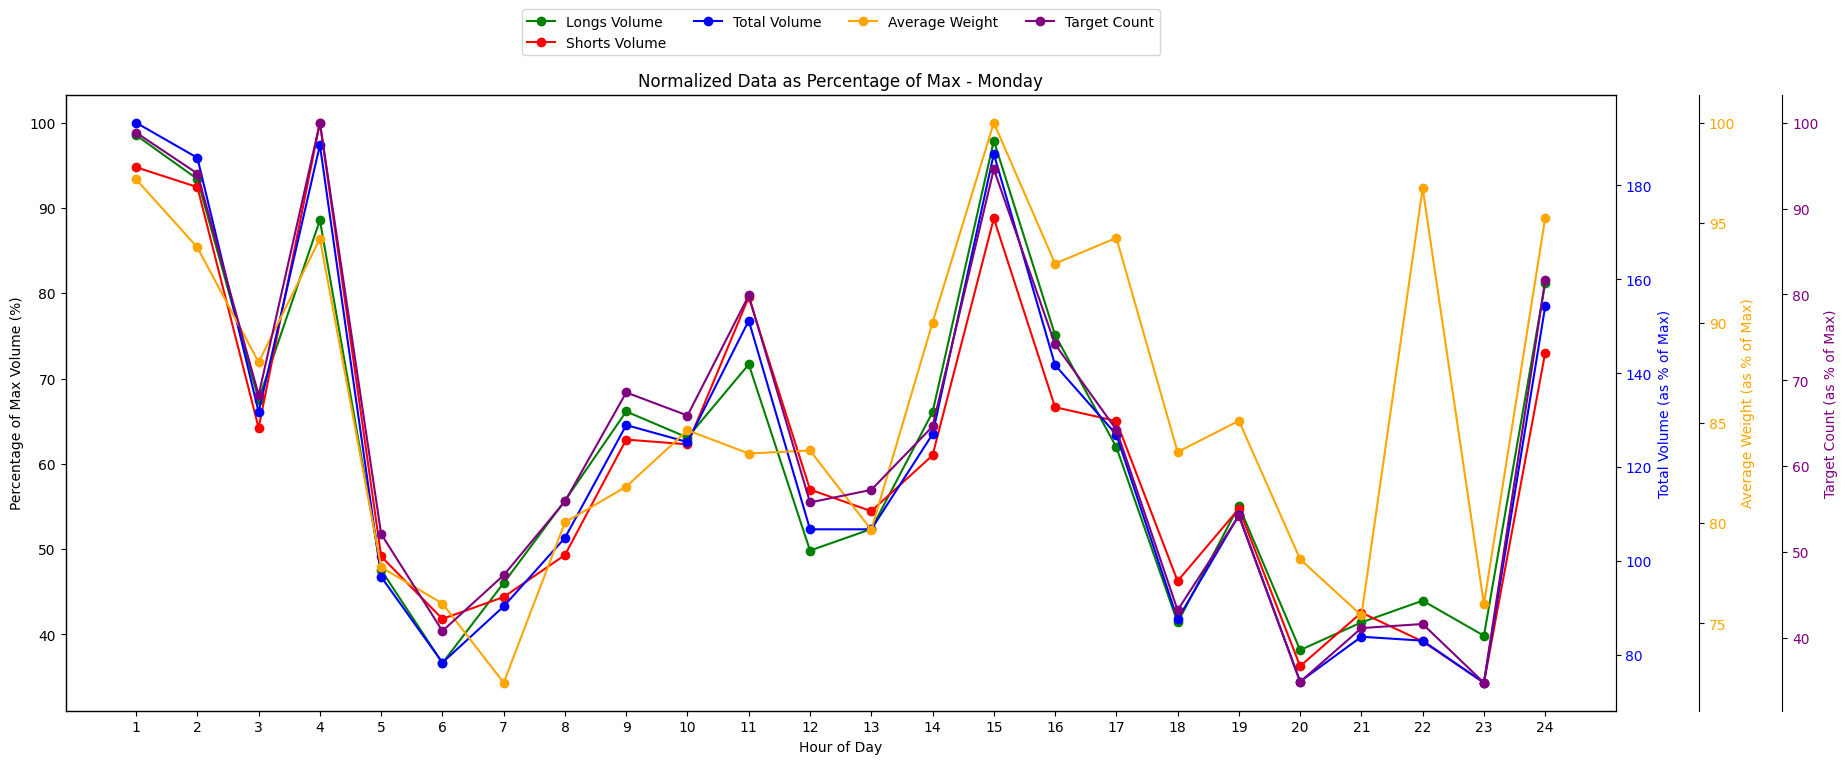

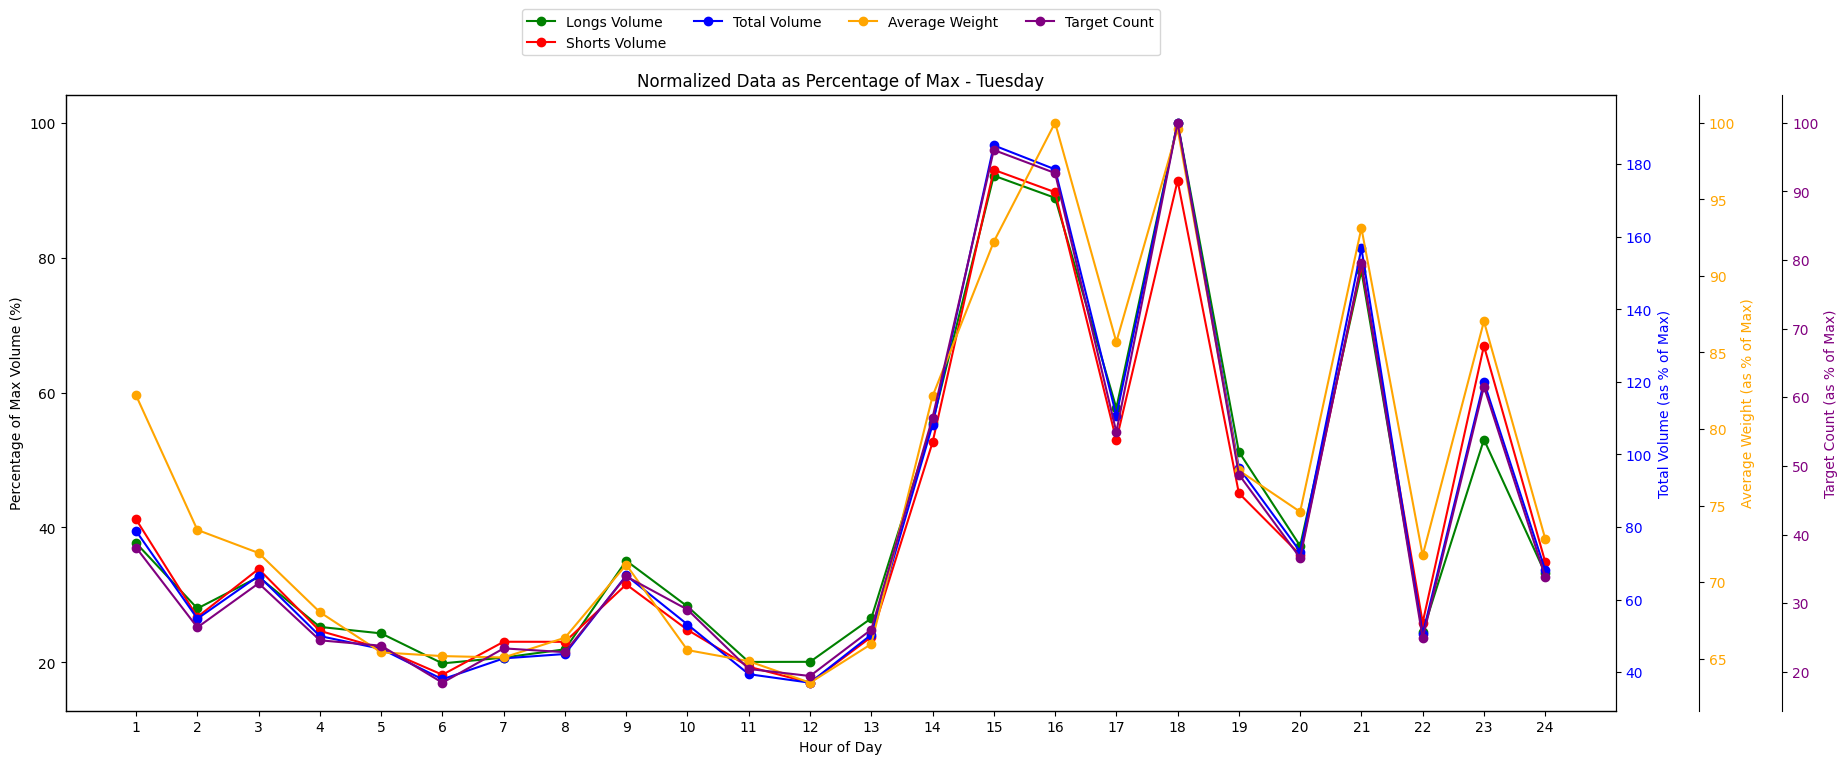

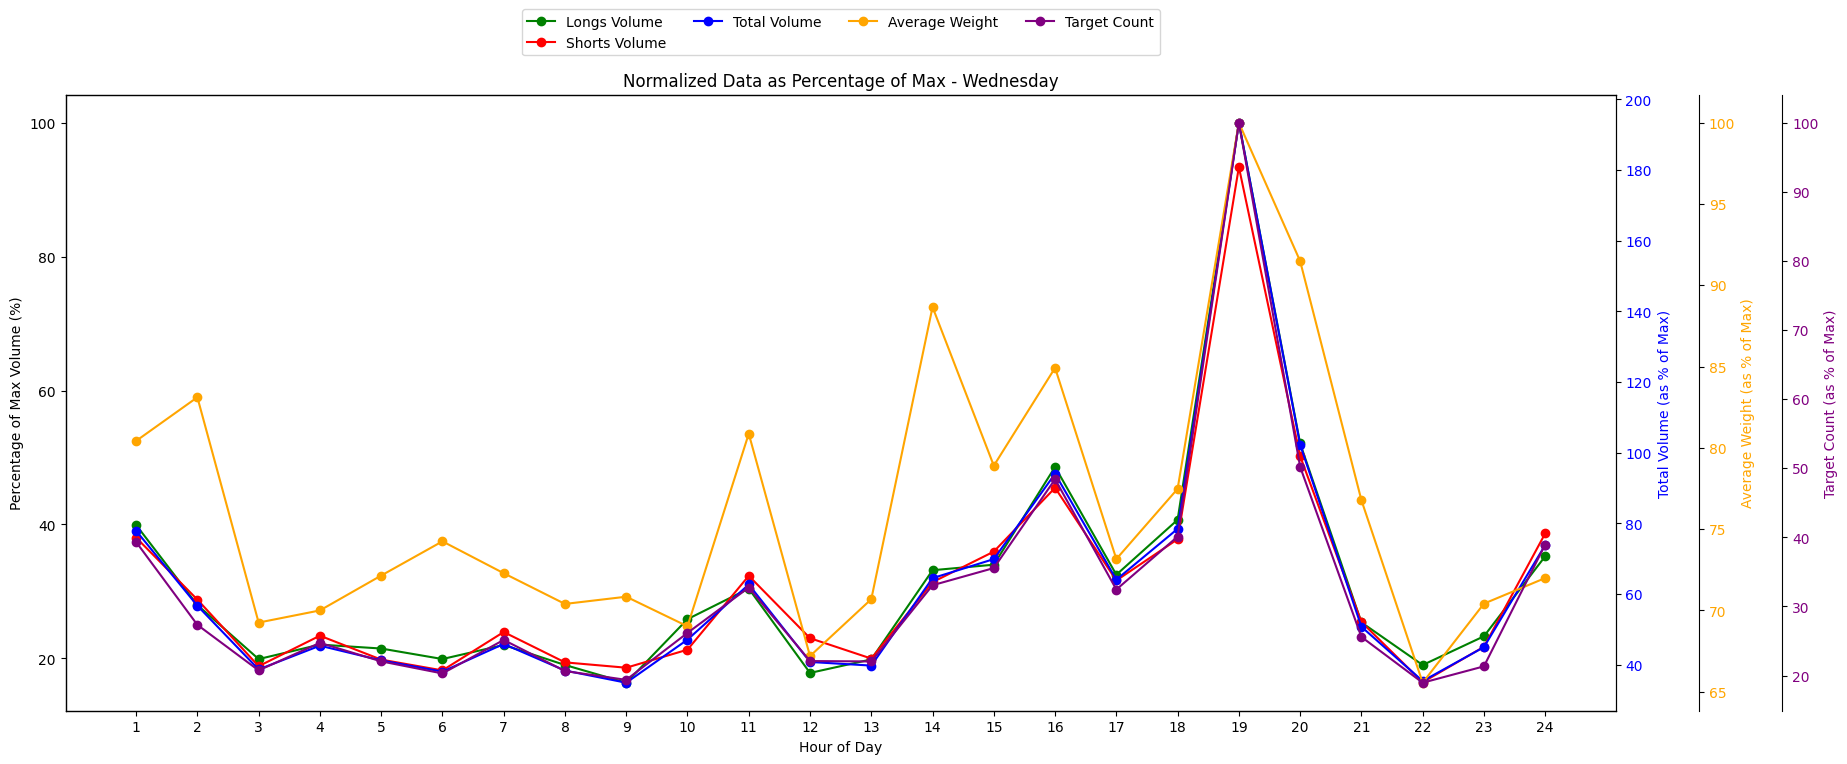

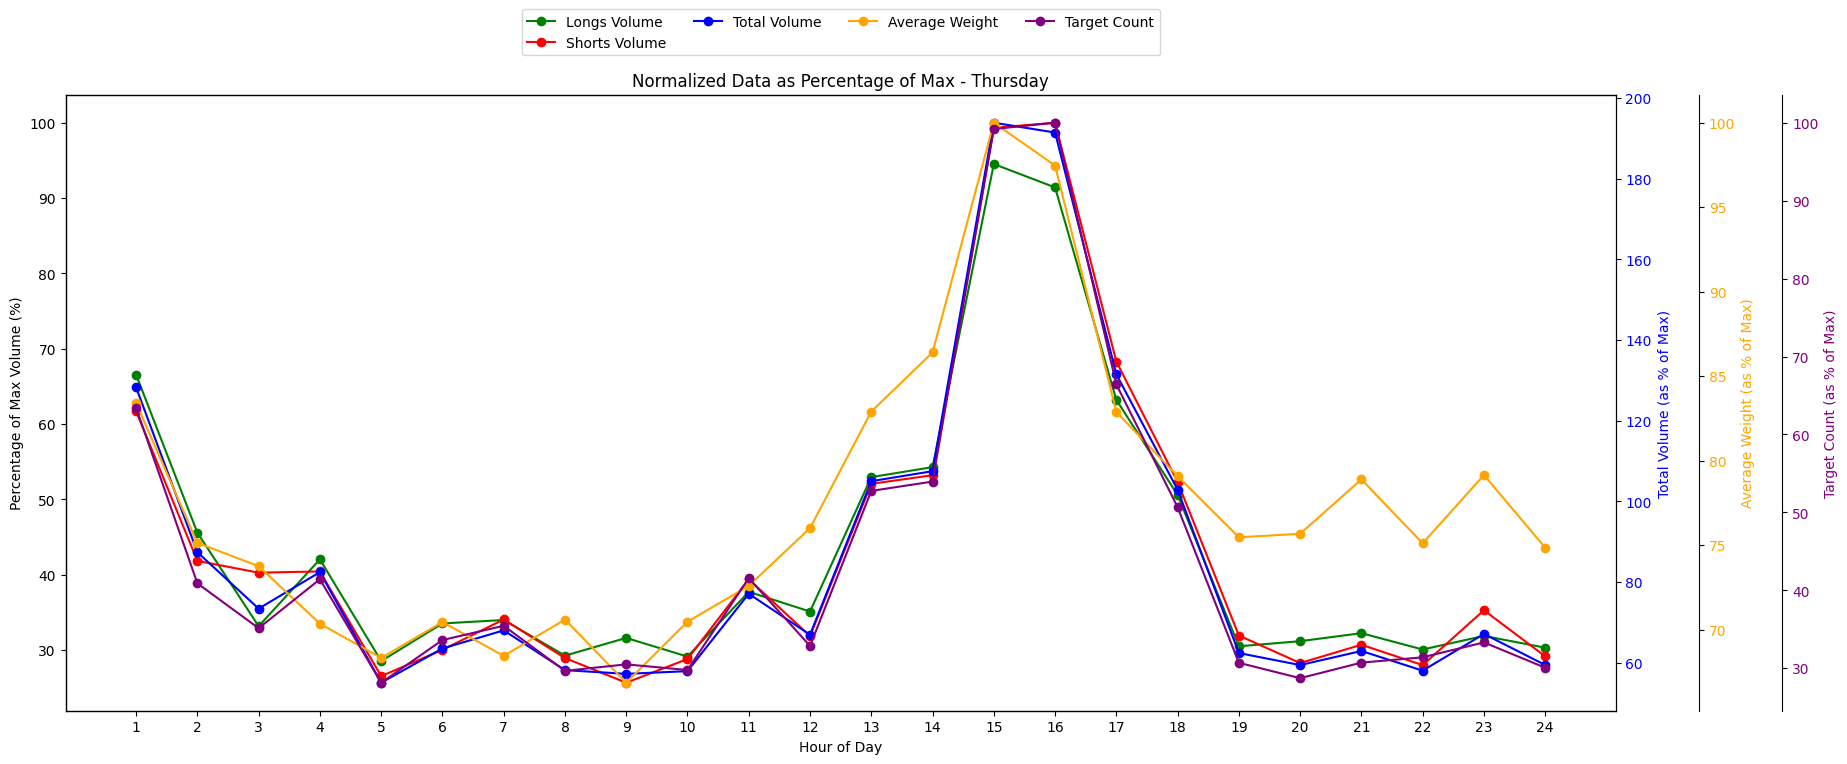

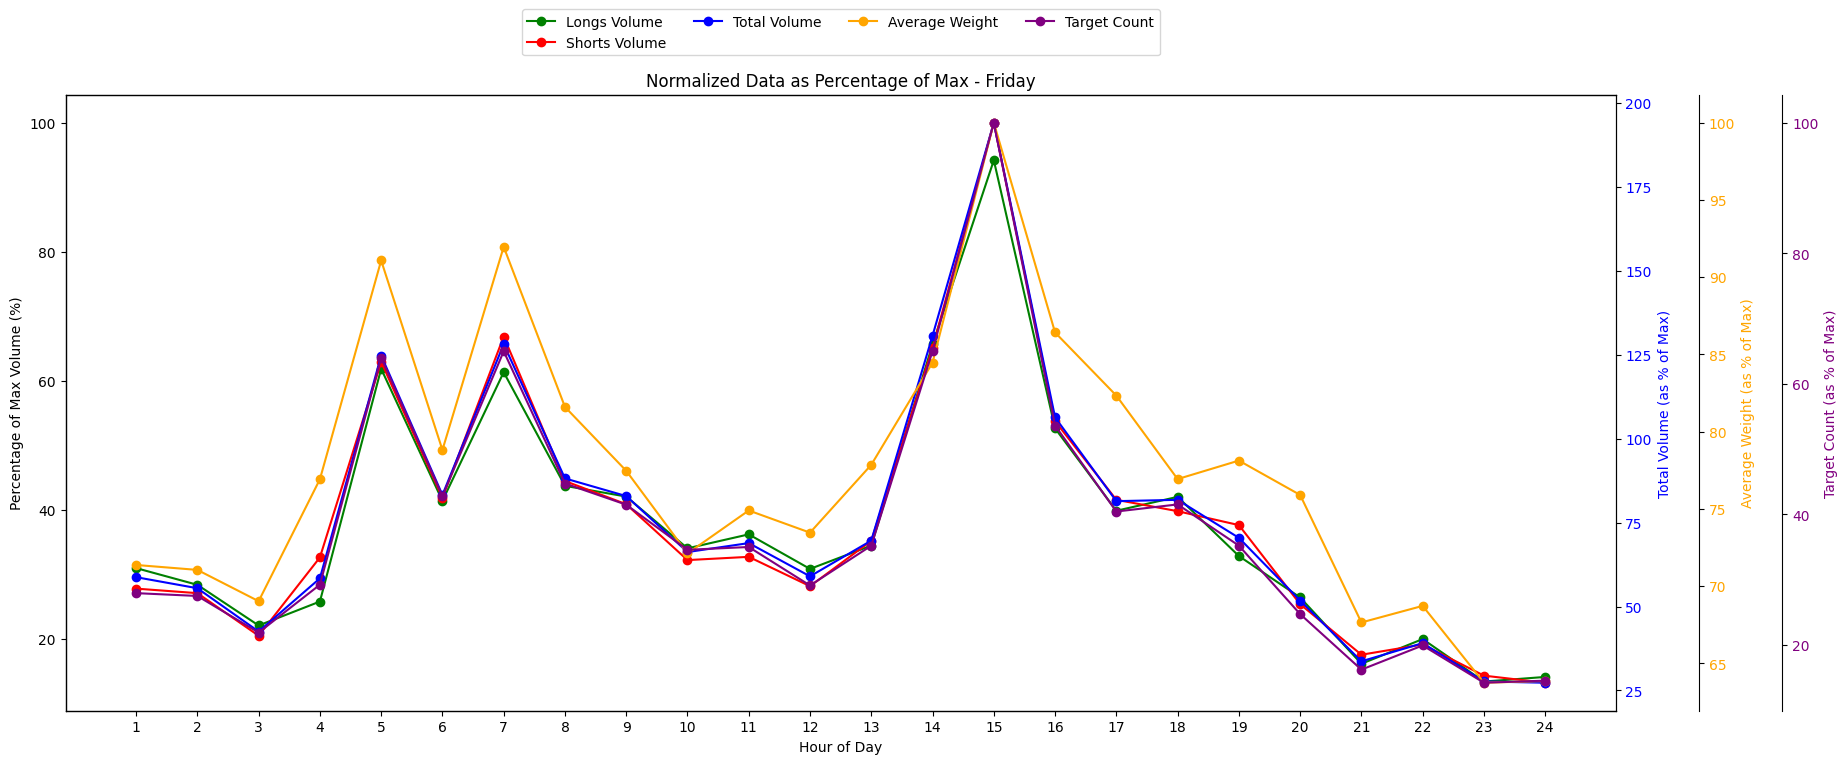

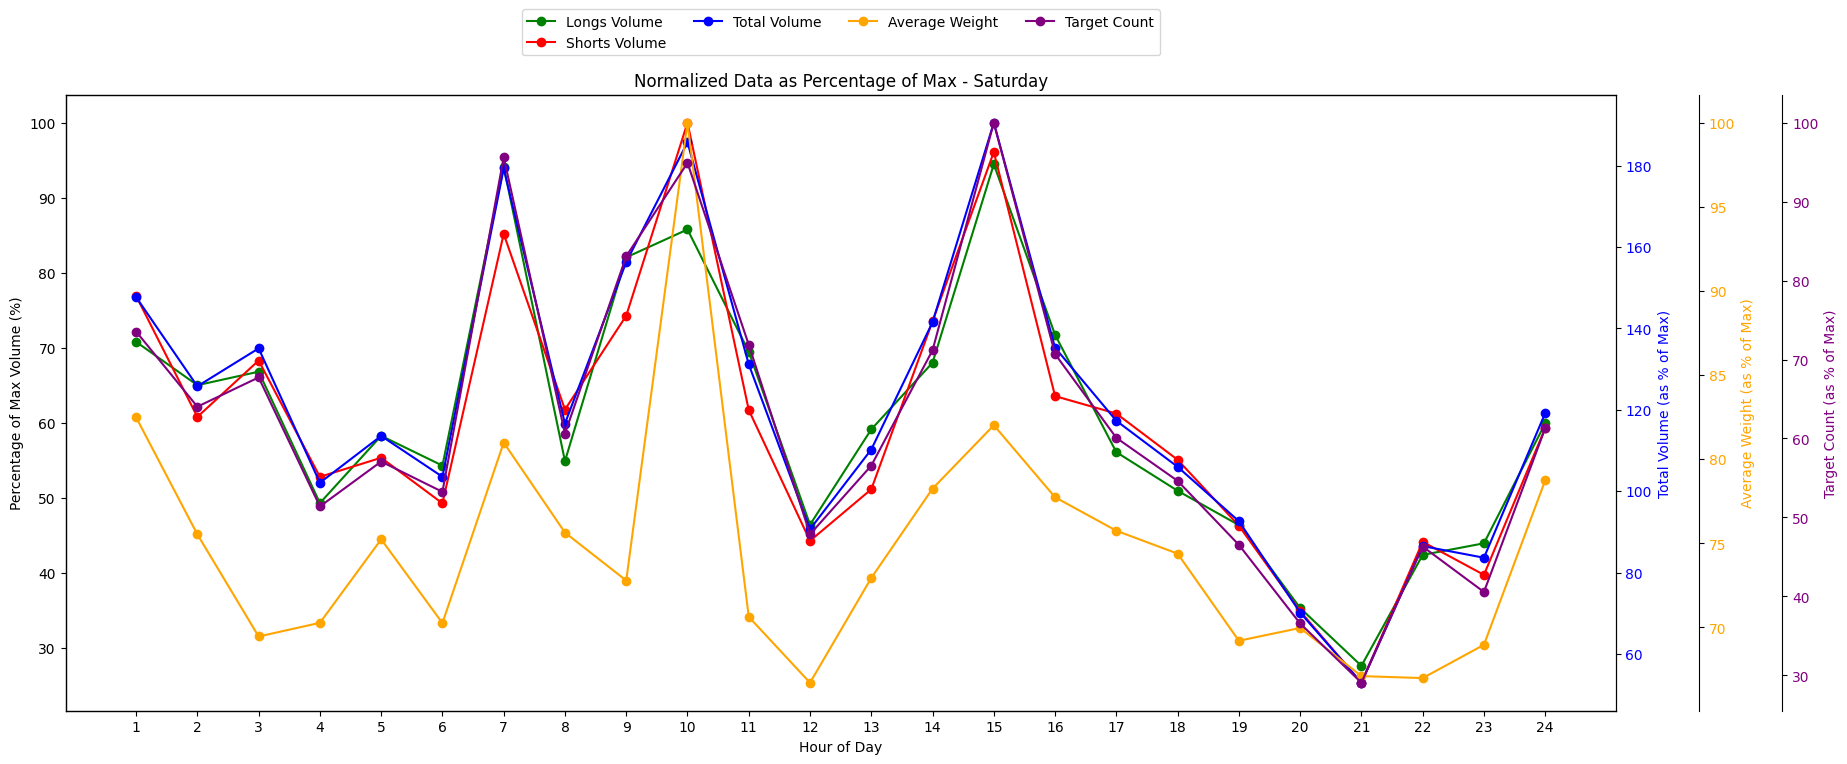

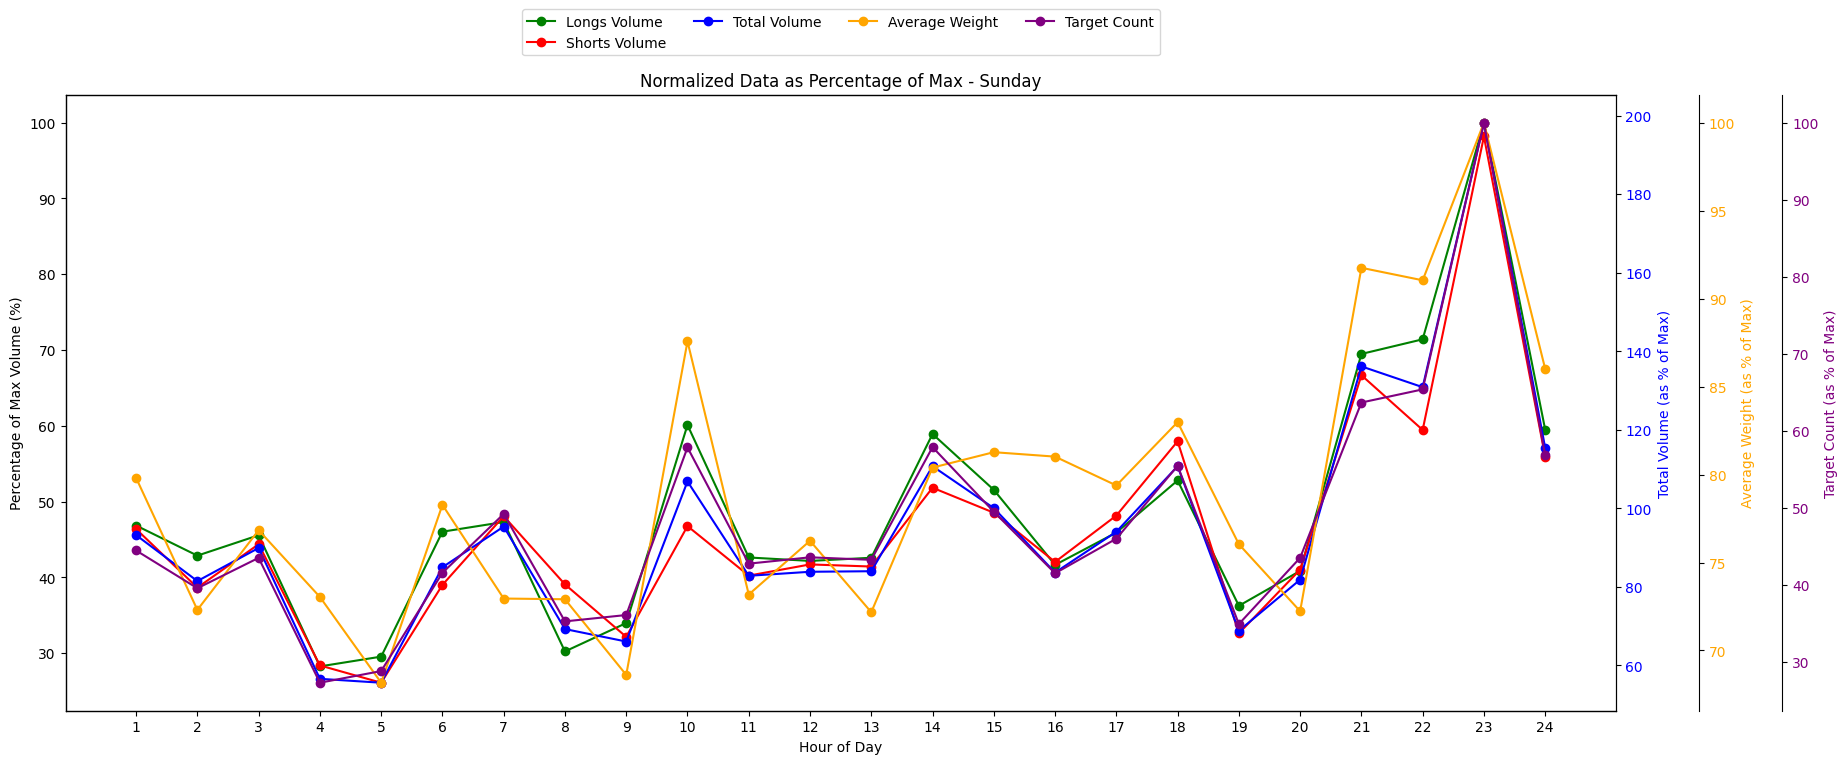

In [ ]:

# Side distribution by hour for each day of the week
for day in range(7):
    daily_data = data[data.index.dayofweek == day]
    hourly_side_counts = daily_data.groupby(daily_data.index.hour)['side'].value_counts().unstack(fill_value=0)
    hourly_average_weight = daily_data.groupby(daily_data.index.hour)['weight'].mean()
    hourly_target_count = daily_data[daily_data['target'] == 1].groupby(daily_data[daily_data['target'] == 1].index.hour)['target'].count()

    # Normalize all data to 100% of the maximum in the period
    max_total_volume = hourly_side_counts.values.max()
    hourly_side_counts_normalized = hourly_side_counts / max_total_volume * 100
    hourly_average_weight_normalized = hourly_average_weight / hourly_average_weight.max() * 100
    hourly_target_count_normalized = hourly_target_count / hourly_target_count.max() * 100

    # Adjust x_positions for 1-based indexing
    x_positions = np.arange(1, len(hourly_side_counts_normalized) + 1) * 1.5

    # Plot normalized data
    fig, ax = plt.subplots(figsize=(20, 8))  # Increased figure size for better spacing

    # Plot longs and shorts as lines
    ax.plot(x_positions, hourly_side_counts_normalized[1], color='green', marker='o', label="Longs Volume", zorder=3)
    ax.plot(x_positions, hourly_side_counts_normalized[-1], color='red', marker='o', label="Shorts Volume", zorder=3)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Percentage of Max Volume (%)')

    # Plot total volume as a line
    ax2 = ax.twinx()
    ax2.plot(x_positions, hourly_side_counts_normalized.sum(axis=1), color='blue', marker='o', label='Total Volume', zorder=4)
    ax2.set_ylabel('Total Volume (as % of Max)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Plot average weight as a line
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
    ax3.plot(x_positions, hourly_average_weight_normalized, color='orange', marker='o', label='Average Weight', zorder=2)
    ax3.set_ylabel('Average Weight (as % of Max)', color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')

    # Plot target count as a line
    ax4 = ax.twinx()
    ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth axis
    ax4.plot(x_positions, hourly_target_count_normalized, color='purple', marker='o', label='Target Count', zorder=1)
    ax4.set_ylabel('Target Count (as % of Max)', color='purple')
    ax4.tick_params(axis='y', labelcolor='purple')

    # Combine legends and bring to the top
    lines, labels = [], []
    for ax_ in [ax, ax2, ax3, ax4]:
        for line, label in zip(ax_.get_legend_handles_labels()[0], ax_.get_legend_handles_labels()[1]):
            lines.append(line)
            labels.append(label)
    ax.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

    # Adjust x-axis ticks for better spacing
    ax.set_xticks(x_positions)
    ax.set_xticklabels(range(1, 25), rotation=0)  # Updated x-axis ticks to range 1-24

    plt.title(f'Normalized Data as Percentage of Max - {day_names[day]}')
    plt.show()

/tmp/ipykernel_6965/3223329148.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_resampled = data['price'].resample('H').mean()


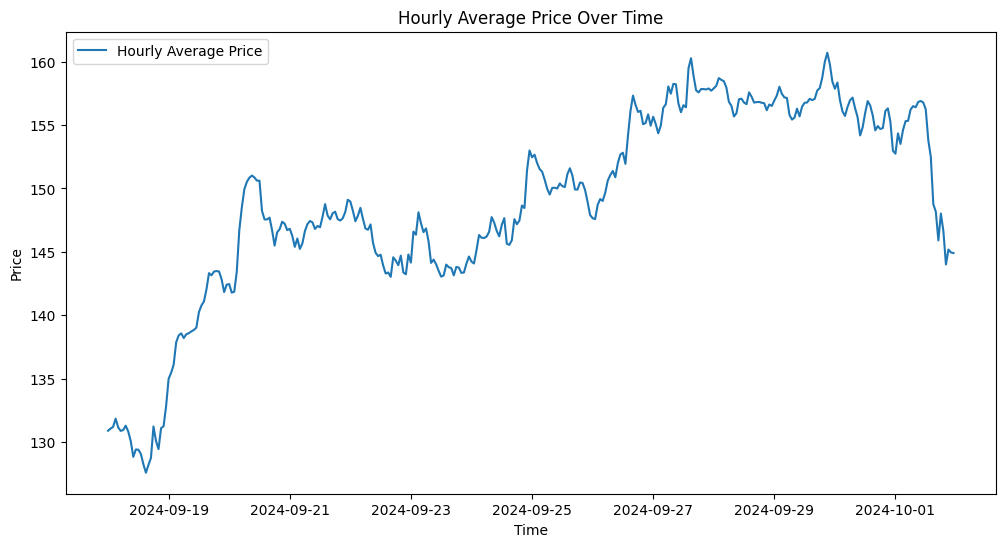

AttributeError: 'DatetimeIndexResampler' object has no attribute 'value_counts'

In [13]:

# Resample to hourly averages for price
price_resampled = data['price'].resample('H').mean()
plt.figure(figsize=(12, 6))
plt.plot(price_resampled, label='Hourly Average Price')
plt.title('Hourly Average Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Side distribution over time
side_counts = data['side'].resample('D').value_counts().unstack()
side_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Daily Side Distribution')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Side')
plt.show()

In [ ]:
# for name, dataset in datasets.items():
#     print(f"Dataset: {name}")
#     print(dataset.head())
#     print()

Dataset: agg_trades
                     bid_max_price  ask_max_price  bid_min_price  \
timestamp_ns                                                       
1726617603500000000     131.468002     131.466995     131.468002   
1726617603500000000   60281.101562   60281.000000   60281.101562   
1726617603500000000    2340.600098    2340.590088    2340.600098   
1726617603750000000     131.468002     131.466995     131.460007   
1726617603750000000   60285.398438   60285.300781   60281.101562   

                     ask_min_price  bid_mean_price  ask_mean_price  bid_count  \
timestamp_ns                                                                    
1726617603500000000     131.466995      131.468002      131.466995        2.0   
1726617603500000000   60281.000000    60281.105469    60281.000000       24.0   
1726617603500000000    2340.590088     2340.600098     2340.590088        5.0   
1726617603750000000     131.455994      131.462601      131.462799        5.0   
17266176037500000

In [ ]:
# log_loss_values = {
#     "Log Loss with preprocessed target weights": 0.6778302098403703,
#     "Weighted Log Loss with preprocessed target weights": 0.6757554081125899,
#     "Log Loss": 0.6780970515291622,
#     "Weighted Log Loss": 0.6647457404007143,
#     "Simple Max's Log Loss": 0.6775086526037322
# }

# log_loss_values
# target_value = 0.681868

# # Calculate differences with the target value
# differences_with_keys = {key: target_value - value  for key, value in log_loss_values.items()}

# # Find the minimum and maximum differences
# min_diff_key = min(differences_with_keys, key=differences_with_keys.get)
# max_diff_key = max(differences_with_keys, key=differences_with_keys.get)

# min_diff_key, differences_with_keys[min_diff_key], max_diff_key, differences_with_keys[max_diff_key]


('Log Loss', 0.0037709484708378094, 'Weighted Log Loss', 0.017122259599285705)

In [ ]:
# unique_values = {}

# # Extract unique values
# for name, df in datasets.items():
#     unique_values[name] = {col: df[col].unique().tolist() for col in df.columns}

# # Print unique values for each dataset
# for dataset, columns in unique_values.items():
#     print(f"Unique values in {dataset}:")
#     for col, values in columns.items():
#         print(f"  Column: {col} | Unique Values: {values[:10]}{'...' if len(values) > 10 else ''}")
#     print('-' * 50)

Unique values in agg_trades:
  Column: bid_max_price | Unique Values: [131.46800231933594, 60281.1015625, 2340.60009765625, 60285.3984375, 131.4290008544922, 60284.19921875, 2340.489990234375, 60279.80078125, 2340.219970703125, 2340.239990234375]...
  Column: ask_max_price | Unique Values: [131.4669952392578, 60281.0, 2340.590087890625, 60285.30078125, 131.4459991455078, nan, 2340.22998046875, 60279.8984375, 131.44000244140625, 60283.80078125]...
  Column: bid_min_price | Unique Values: [131.46800231933594, 60281.1015625, 2340.60009765625, 131.4600067138672, 131.4290008544922, 60277.6015625, 2340.489990234375, 2340.010009765625, 2340.239990234375, 131.4409942626953]...
  Column: ask_min_price | Unique Values: [131.4669952392578, 60281.0, 2340.590087890625, 131.45599365234375, 131.43099975585938, 60277.5, 2340.010009765625, nan, 2340.22998046875, 60279.8984375]...
  Column: bid_mean_price | Unique Values: [131.46800231933594, 60281.10546875, 2340.60009765625, 131.4626007080078, 60282.19

In [ ]:
# #preprocessing
# target_solusdt_preprocessed = datasets.get("target_solusdt")

# def adjust_weight(weight: float) -> float:
#     if weight > 10:
#         return weight / 100
#     elif weight > 1:
#         return weight / 10
#     return weight

# target_solusdt_preprocessed['weight'] = target_solusdt_preprocessed['weight'].map(adjust_weight)
# # target_solusdt_preprocessed.describe()

# target_data_solusdt_preprocessed = datasets.get("target_data_solusdt")
# # target_data_solusdt_preprocessed.describe()



In [ ]:
# # let's merge both solusdt datasets
# common_indexes = target_data_solusdt_preprocessed.index.intersection(target_solusdt_preprocessed.index)
# unique_to_target_data = target_data_solusdt_preprocessed.index.difference(target_solusdt_preprocessed.index)
# unique_to_target_solusdt = target_solusdt_preprocessed.index.difference(target_data_solusdt_preprocessed.index)

# # Prepare a summary to check that inxdes (timestamp_ns are the same in both datasets)
# index_comparison_summary = {
#     "Total indexes in target_data_solusdt_preprocessed": len(target_data_solusdt_preprocessed.index),
#     "Total indexes in target_solusdt_preprocessed": len(target_solusdt_preprocessed.index),
#     "Common indexes": len(common_indexes),
#     "Indexes unique to target_data_solusdt_preprocessed": len(unique_to_target_data),
#     "Indexes unique to target_solusdt_preprocessed": len(unique_to_target_solusdt),
# }
# # print(index_comparison_summary)

# target_solusdt_full = target_data_solusdt_preprocessed.merge(
#     target_solusdt_preprocessed,
#     left_index=True,
#     right_index=True,
#     how='outer'  # Choose 'inner' join for common rows; use 'outer', 'left', or 'right' as needed
# )
# # print(target_solusdt_full)

In [86]:
agg_trades_preprocessed.head()

bid_max_price  ask_max_price  bid_min_price  \
timestamp_ns                                                       
1726617603500000000     131.468002     131.466995     131.468002   
1726617603500000000   60281.101562   60281.000000   60281.101562   
1726617603500000000    2340.600098    2340.590088    2340.600098   
1726617603750000000     131.468002     131.466995     131.460007   
1726617603750000000   60285.398438   60285.300781   60281.101562   

                     ask_min_price  bid_mean_price  ask_mean_price  bid_count  \
timestamp_ns                                                                    
1726617603500000000     131.466995      131.468002      131.466995        2.0   
1726617603500000000   60281.000000    60281.105469    60281.000000       24.0   
1726617603500000000    2340.590088     2340.600098     2340.590088        5.0   
1726617603750000000     131.455994      131.462601      131.462799        5.0   
1726617603750000000   60281.000000    60282.195312    60281.453125       72.0   

                     ask_count  bid_amount  ask_amount instrument  
timestamp_ns                                                       
1726617603500000000        1.0       2.000       7.000    SOLUSDT  
1726617603500000000       11.0       2.227       0.484    BTCUSDT  
1726617603500000000        5.0       2.021       0.987    ETHUSDT  
1726617603750000000       15.0     106.000     164.000    SOLUSDT  
1726617603750000000       19.0       5.202       5.604    BTCUSDT

In [ ]:
# let's check agg_trades_preprocessed and  target_solusdt_full datasets

common_indexes = agg_trades_preprocessed.index.intersection(target_solusdt_full.index)
unique_to_agg_trades = agg_trades_preprocessed.index.difference(target_solusdt_full.index)
unique_to_target_solusdt = target_solusdt_full.index.difference(agg_trades_preprocessed.index)

# Prepare a summary
index_comparison_summary = {
    "Total indexes in agg_trades_preprocessed": len(agg_trades_preprocessed.index),
    "Total indexes in target_solusdt_full": len(target_solusdt_full.index),
    "Common indexes": len(common_indexes),
    "Indexes unique to agg_trades_preprocessed": len(unique_to_agg_trades),
    "Indexes unique to target_solusdt_full": len(unique_to_target_solusdt),

}
print(index_comparison_summary)

{'Total indexes in agg_trades_preprocessed': 14515158, 'Total indexes in target_solusdt_full': 9163347, 'Common indexes': 40, 'Indexes unique to agg_trades_preprocessed': 4838346, 'Indexes unique to target_solusdt_full': 7877249}


In [93]:
orderbook_solusdt = datasets.get("orderbook_solusdt")
orderbook_solusdt

asks[0].price  asks[0].amount  bids[0].price  \
timestamp_ns                                                        
1726617601032619000     131.468002           233.0     131.466995   
1726617601618093000     131.468002           233.0     131.466995   
1726617603503948000     131.468002           159.0     131.466995   
1726617603555395000     131.460007            58.0     131.459000   
1726617603605917000     131.460007           115.0     131.459000   
...                            ...             ...            ...   
1727827199711592000     145.072006            31.0     145.070999   
1727827199762003000     145.072006           127.0     145.070999   
1727827199815751000     145.072006           168.0     145.070999   
1727827199867043000     145.072006           169.0     145.070999   
1727827199968723000     145.072006           169.0     145.070999   

                     bids[0].amount  asks[1].price  asks[1].amount  \
timestamp_ns                                                         
1726617601032619000           157.0     131.470993             1.0   
1726617601618093000           157.0     131.470993             1.0   
1726617603503948000           151.0     131.470993             1.0   
1726617603555395000            59.0     131.464996            66.0   
1726617603605917000            27.0     131.464005            19.0   
...                             ...            ...             ...   
1727827199711592000            77.0     145.072998             2.0   
1727827199762003000            77.0     145.072998             3.0   
1727827199815751000            63.0     145.072998             3.0   
1727827199867043000            57.0     145.072998             3.0   
1727827199968723000            57.0     145.072998             3.0   

                     bids[1].price  bids[1].amount  asks[2].price  \
timestamp_ns                                                        
1726617601032619000     131.466003             2.0     131.472000   
1726617601618093000     131.466003             2.0     131.472000   
1726617603503948000     131.466003             2.0     131.472000   
1726617603555395000     131.457993           228.0     131.466995   
1726617603605917000     131.457993             1.0     131.464996   
...                            ...             ...            ...   
1727827199711592000     145.067993            31.0     145.074997   
1727827199762003000     145.067993            28.0     145.076004   
1727827199815751000     145.067993            28.0     145.076004   
1727827199867043000     145.067993            28.0     145.076004   
1727827199968723000     145.067993            28.0     145.076004   

                     asks[2].amount  ...  asks[18].price  asks[18].amount  \
timestamp_ns                         ...                                    
1726617601032619000             1.0  ...      131.490005            149.0   
1726617601618093000             1.0  ...      131.490005            149.0   
1726617603503948000             1.0  ...      131.490005            149.0   
1726617603555395000           109.0  ...      131.487000             44.0   
1726617603605917000           135.0  ...      131.485001            153.0   
...                             ...  ...             ...              ...   
1727827199711592000             1.0  ...      145.095993             38.0   
1727827199762003000            24.0  ...      145.095993             38.0   
1727827199815751000            24.0  ...      145.095993             38.0   
1727827199867043000            24.0  ...      145.095001             17.0   
1727827199968723000            24.0  ...      145.095001             17.0   

                     bids[18].price  bids[18].amount  asks[19].price  \
timestamp_ns                                                           
1726617601032619000      131.440994             98.0      131.490997   
1726617601618093000      131.440994             98.0      131.490997   
1726617603503948000     

In [94]:
common_timestamps = target_solusdt_full.index.intersection(orderbook_solusdt.index)
unique_to_target = target_solusdt_full.index.difference(orderbook_solusdt.index)
unique_to_orderbook = orderbook_solusdt.index.difference(target_solusdt_full.index)
# Calculate differences in target data
target_diffs = target_solusdt_full.index.to_series().diff().dropna()
orderbook_diffs = orderbook_solusdt.index.to_series().diff().dropna()

# Summarize the differences
print("Target dataset time gap statistics:\n", target_diffs.describe())
print("Order book dataset time gap statistics:\n", orderbook_diffs.describe())


Target dataset time gap statistics:
 count    9.163346e+06
mean     1.320038e+08
std      3.735655e+08
min      0.000000e+00
25%      2.000000e+03
50%      1.400000e+04
75%      6.401200e+07
max      1.975582e+10
Name: timestamp_ns, dtype: float64
Order book dataset time gap statistics:
 count    2.050486e+07
mean     5.899083e+07
std      2.785724e+07
min      0.000000e+00
25%      5.164600e+07
50%      5.255500e+07
75%      5.328500e+07
max      5.002144e+09
Name: timestamp_ns, dtype: float64


/home/svv/.cache/pypoetry/virtualenvs/timeseries-forecaster-klrvJbV1-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


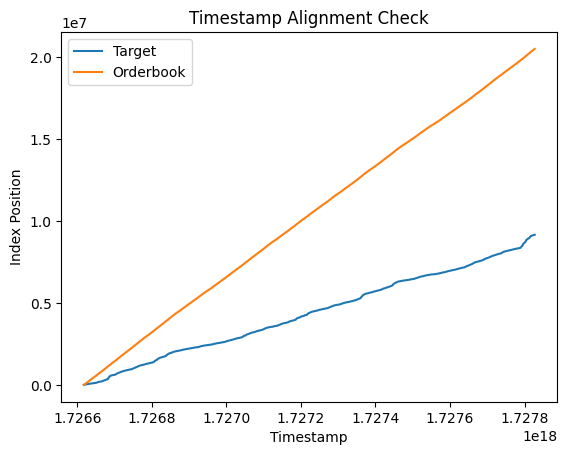

In [95]:
import matplotlib.pyplot as plt

plt.plot(target_solusdt_full.index, range(len(target_solusdt_full)), label='Target')
plt.plot(orderbook_solusdt.index, range(len(orderbook_solusdt)), label='Orderbook')
plt.xlabel('Timestamp')
plt.ylabel('Index Position')
plt.legend()
plt.title('Timestamp Alignment Check')
plt.show()


In [91]:

df = orderbook_solusdt_preprocessed
# Calculate cumulative volume for bucket segmentation
df['cum_volume'] = df[['bids[0].amount', 'asks[0].amount']].sum(axis=1).cumsum()
bucket_size = 10000  # Example bucket size
df['bucket'] = (df['cum_volume'] // bucket_size).astype(int)

# Group by bucket and calculate imbalance
buckets = df.groupby('bucket').agg(
    buy_volume=('asks[0].amount', 'sum'),
    sell_volume=('bids[0].amount', 'sum')
)
buckets['imbalance'] = abs(buckets['buy_volume'] - buckets['sell_volume'])
buckets['normalized_imbalance'] = buckets['imbalance'] / bucket_size

# Calculate VPIN as a moving average
buckets['VPIN'] = buckets['normalized_imbalance'].rolling(window=50).mean()

In [92]:
buckets

buy_volume  sell_volume  imbalance  normalized_imbalance      VPIN
bucket                                                                    
0           3356.0       6474.0     3118.0                0.3118       NaN
1           1054.0       8744.0     7690.0                0.7690       NaN
2           3359.0       6542.0     3183.0                0.3183       NaN
3           6592.0       3604.0     2988.0                0.2988       NaN
4           5825.0       4317.0     1508.0                0.1508       NaN
...            ...          ...        ...                   ...       ...
653262      3065.0       6201.0     3136.0                0.3136  0.409538
653263      3566.0       6854.0     3288.0                0.3288  0.415132
653264      7223.0       4621.0     2602.0                0.2602  0.416916
653265     17152.0      11896.0     5256.0                0.5256  0.425890
653266      8419.0       1770.0     6649.0                0.6649  0.437566

[644534 rows x 5 columns]

In [80]:
orderbook_embedding_preprocessed = datasets.get("orderbook_embedding")
orderbook_embedding_preprocessed.describe()

mid_price    vwap_1_lvl    vwap_3_lvl    vwap_5_lvl   vwap_10_lvl
count  4.127136e+07  4.127136e+07  4.127136e+07  4.127136e+07  4.127136e+07
mean   3.227235e+04  3.227234e+04  3.227234e+04  3.227234e+04  3.227234e+04
std    3.051129e+04  3.051129e+04  3.051129e+04  3.051129e+04  3.051129e+04
min    2.275700e+03  2.275805e+03  2.275644e+03  2.275593e+03  2.275530e+03
25%    2.614505e+03  2.614502e+03  2.614503e+03  2.614503e+03  2.614501e+03
50%    2.693355e+03  2.693359e+03  2.693358e+03  2.693360e+03  2.693356e+03
75%    6.344995e+04  6.344999e+04  6.344999e+04  6.344998e+04  6.344998e+04
max    6.644985e+04  6.645000e+04  6.644998e+04  6.644995e+04  6.644981e+04

In [89]:
orderbook_embedding_preprocessed

mid_price    vwap_1_lvl    vwap_3_lvl    vwap_5_lvl  \
timestamp_ns                                                                  
1726617601297832000  60281.050781  60281.039062  60281.035156  60281.019531   
1726617601619148000   2340.595215   2340.592529   2340.596680   2340.614502   
1726617601937205000  60281.050781  60281.031250  60281.031250  60281.015625   
1726617603501883000   2340.595215   2340.592529   2340.591064   2340.591064   
1726617603503510000  60281.050781  60281.023438  60281.015625  60280.992188   
...                           ...           ...           ...           ...   
1727827199876890000   2446.854980   2446.859863   2446.859375   2446.860352   
1727827199892935000  60776.750000  60776.781250  60776.796875  60776.800781   
1727827199928810000   2446.854980   2446.859863   2446.859375   2446.860596   
1727827199944091000  60776.750000  60776.781250  60776.796875  60776.800781   
1727827199980381000   2446.854980   2446.859863   2446.859375   2446.860352   

                      vwap_10_lvl instrument  
timestamp_ns                                  
1726617601297832000  60281.132812    BTCUSDT  
1726617601619148000   2340.603271    ETHUSDT  
1726617601937205000  60281.140625    BTCUSDT  
1726617603501883000   2340.586914    ETHUSDT  
1726617603503510000  60281.015625    BTCUSDT  
...                           ...        ...  
1727827199876890000   2446.854492    ETHUSDT  
1727827199892935000  60776.808594    BTCUSDT  
1727827199928810000   2446.854736    ETHUSDT  
1727827199944091000  60777.101562    BTCUSDT  
1727827199980381000   2446.856689    ETHUSDT  

[41271361 rows x 6 columns]

In [88]:
target_solusdt_full

side       price  amount    weight  target
timestamp_ns                                                   
1726617603492082000     1  131.466995     7.0  0.397396       0
1726617603512695000     1  131.466995     1.0  0.150202       0
1726617603512698000     1  131.466003     2.0  0.207696       0
1726617603543949000    -1  131.460007     8.0  0.433219       1
1726617603710144000     1  131.459000     1.0  0.120686       0
...                   ...         ...     ...       ...     ...
1727827199560359000     1  145.072998     3.0  0.021153       0
1727827199560366000     1  145.072006     1.0  0.029028       1
1727827199560372000     1  145.072006     3.0  0.050278       1
1727827199721740000     1  145.070999     9.0  0.129024       1
1727827199762003000    -1  145.072006   127.0  0.999216       1

[9163347 rows x 5 columns]

In [29]:
# Feature engineering functions
def trades_balance(trades_df: pd.DataFrame, window: str | int) -> pd.Series:
    """Calculate trades balance over a rolling window."""
    sells = trades_df["ask_amount"].rolling(window=window, min_periods=1).sum()
    buys = trades_df["bid_amount"].rolling(window=window, min_periods=1).sum()
    return (sells - buys) / (sells + buys + 1e-8)

def calc_imbalance(lobs: pd.DataFrame) -> pd.Series:
    """Calculate order book imbalance for the first level."""
    bid_amount = lobs["bids[0].amount"]
    ask_amount = lobs["asks[0].amount"]
    return (bid_amount - ask_amount) / (bid_amount + ask_amount + 1e-8)

def vwap(books_df: pd.DataFrame, lvl_count: int) -> pd.Series:
    """Calculate Volume Weighted Average Price (VWAP)."""
    ask_weighted_price = sum(
        books_df[f"asks[{i}].price"] * books_df[f"asks[{i}].amount"]
        for i in range(lvl_count)
    )
    ask_volume = sum(books_df[f"asks[{i}].amount"] for i in range(lvl_count))

    bid_weighted_price = sum(
        books_df[f"bids[{i}].price"] * books_df[f"bids[{i}].amount"]
        for i in range(lvl_count)
    )
    bid_volume = sum(books_df[f"bids[{i}].amount"] for i in range(lvl_count))

    total_weighted_price = ask_weighted_price + bid_weighted_price
    total_volume = ask_volume + bid_volume

    return total_weighted_price / (total_volume + 1e-8)

In [4]:
# Ensure correct time index and reset index
for df in datasets.values():
    df.reset_index(inplace=True)
    df['timestamp_ns'] = df['timestamp_ns'].astype('int64')  # Ensure correct dtype
    df.sort_values('timestamp_ns', inplace=True)



# Create separate DataFrames from initial datasets
agg_trades_SOLUSDT = datasets["agg_trades"][datasets["agg_trades"]['instrument'] == 'SOLUSDT'].copy()
agg_trades_BTCUSDT = datasets["agg_trades"][datasets["agg_trades"]['instrument'] == 'BTCUSDT'].copy()
agg_trades_ETHUSDT = datasets["agg_trades"][datasets["agg_trades"]['instrument'] == 'ETHUSDT'].copy()

orderbook_embedding_BTCUSDT = datasets["orderbook_embedding"][datasets["orderbook_embedding"]['instrument'] == 'BTCUSDT'].copy()
orderbook_embedding_ETHUSDT = datasets["orderbook_embedding"][datasets["orderbook_embedding"]['instrument'] == 'ETHUSDT'].copy()

orderbook_solusdt = datasets["orderbook_solusdt"]
target_data_solusdt = datasets["target_data_solusdt"]
target_solusdt = datasets["target_solusdt"]

In [5]:
def calc_features(
    lobs: pd.DataFrame,
    agg_trades_SOLUSDT: pd.DataFrame,
    agg_trades_BTCUSDT: pd.DataFrame,
    agg_trades_ETHUSDT: pd.DataFrame,
    orderbook_embedding_BTCUSDT: pd.DataFrame,
    orderbook_embedding_ETHUSDT: pd.DataFrame,
    target_data: pd.DataFrame,
) -> pd.DataFrame:
    # Copy and compute mid_price
    lobs = lobs.copy()
    lobs["mid_price"] = (lobs["asks[0].price"] + lobs["bids[0].price"]) / 2

    # Reset index and ensure timestamp_ns is a column
    lobs = lobs.reset_index()
    target_data = target_data.reset_index()

    # Ensure data is sorted by timestamp_ns
    lobs = lobs.sort_values('timestamp_ns')
    orderbook_embedding_BTCUSDT = orderbook_embedding_BTCUSDT.sort_values('timestamp_ns')
    orderbook_embedding_ETHUSDT = orderbook_embedding_ETHUSDT.sort_values('timestamp_ns')
    target_data = target_data.sort_values('timestamp_ns')

    # Merge lobs with orderbook embeddings
    lobs = pd.merge_asof(
        lobs,
        orderbook_embedding_BTCUSDT[['timestamp_ns', 'mid_price']].rename(columns={'mid_price': 'mid_price_btcusdt'}),
        on='timestamp_ns',
        direction='backward',
        allow_exact_matches=True
    )
    lobs = pd.merge_asof(
        lobs,
        orderbook_embedding_ETHUSDT[['timestamp_ns', 'mid_price']].rename(columns={'mid_price': 'mid_price_ethusdt'}),
        on='timestamp_ns',
        direction='backward',
        allow_exact_matches=True
    )
    lobs = pd.merge_asof(
        lobs,
        target_data[['timestamp_ns', 'side', 'price']],
        on='timestamp_ns',
        direction='backward',
        allow_exact_matches=True
    )

    # Calculate features
    lobs['main_btcusdt_dev'] = (
        lobs["mid_price"] / (lobs["mid_price_btcusdt"] + 1e-6)
    ) * lobs['side']
    lobs['main_ethusdt_dev'] = (
        lobs["mid_price"] / (lobs["mid_price_ethusdt"] + 1e-6)
    ) * lobs['side']
    lobs['distance_to_mid_price'] = (
        lobs['price'] / (lobs['mid_price'] + 1e-6) - 1
    ) * lobs['side']

    # Calculate imbalance
    lobs['imbalance'] = calc_imbalance(lobs) * lobs['side']

    # **Set index of agg_trades DataFrames to 'timestamp_ns'**
    agg_trades_SOLUSDT = agg_trades_SOLUSDT.set_index('timestamp_ns')
    agg_trades_BTCUSDT = agg_trades_BTCUSDT.set_index('timestamp_ns')
    agg_trades_ETHUSDT = agg_trades_ETHUSDT.set_index('timestamp_ns')

    # Compute trades_balance features
    trades_ratio_solusdt = trades_balance(agg_trades_SOLUSDT, 10 * SECOND)
    trades_ratio_btcusdt = trades_balance(agg_trades_BTCUSDT, 10 * SECOND)
    trades_ratio_ethusdt = trades_balance(agg_trades_ETHUSDT, 10 * SECOND)

    # Reset index for merging
    trades_ratio_solusdt = trades_ratio_solusdt.reset_index().sort_values('timestamp_ns')
    trades_ratio_btcusdt = trades_ratio_btcusdt.reset_index().sort_values('timestamp_ns')
    trades_ratio_ethusdt = trades_ratio_ethusdt.reset_index().sort_values('timestamp_ns')

    # Merge trades_ratio into lobs
    lobs = pd.merge_asof(
        lobs,
        trades_ratio_solusdt.rename(columns={0: 'trades_ratio_solusdt'}),
        on='timestamp_ns',
        direction='backward',
        allow_exact_matches=True
    )

    lobs = pd.merge_asof(
        lobs,
        trades_ratio_btcusdt.rename(columns={0: 'trades_ratio_btcusdt'}),
        on='timestamp_ns',
        direction='backward',
        allow_exact_matches=True
    )

    lobs = pd.merge_asof(
        lobs,
        trades_ratio_ethusdt.rename(columns={0: 'trades_ratio_ethusdt'}),
        on='timestamp_ns',
        direction='backward',
        allow_exact_matches=True
    )

    # Prepare features DataFrame
    features = lobs[['timestamp_ns', 'side', 'main_btcusdt_dev', 'main_ethusdt_dev',
                     'distance_to_mid_price', 'imbalance', 'trades_ratio_solusdt', 
                     'trades_ratio_btcusdt', 'trades_ratio_ethusdt']]

    # Set index to timestamp_ns
    features.set_index('timestamp_ns', inplace=True)

    # Forward fill any remaining NaN values
    features = features.ffill()

    return features


In [6]:
X = calc_features(orderbook_solusdt, agg_trades_SOLUSDT, agg_trades_BTCUSDT, agg_trades_ETHUSDT,

                  orderbook_embedding_BTCUSDT, orderbook_embedding_ETHUSDT, target_data_solusdt)

In [16]:
target_solusdt_indexed = target_solusdt.set_index('timestamp_ns')
target_solusdt_indexed_sorted = target_solusdt_indexed.sort_index()
X_sorted = X.sort_index()

In [17]:
# Count unique values in each column
unique_X_timestamp_ns = X_sorted.index.get_level_values('timestamp_ns').nunique()
unique_target_solusdt_timestamp_ns = target_solusdt_indexed_sorted.index.get_level_values('timestamp_ns').nunique()

print(f"Number of unique timestamp_ns_aligned: {unique_X_timestamp_ns}")
print(f"Number of unique timestamp_ns_original: {unique_target_solusdt_timestamp_ns}")

Number of unique timestamp_ns_aligned: 20504861
Number of unique timestamp_ns_original: 7877289


In [25]:
X_unsorted = X.reset_index()
target_solusdt_unsorted = target_solusdt.reset_index()

In [ ]:
X_unsorted["timestamp_ns_big"] = X_unsorted["timestamp_ns"]

timestamp_ns  side  main_btcusdt_dev  main_ethusdt_dev  \
0         1726617601032619000   NaN               NaN               NaN   
1         1726617601618093000   NaN               NaN               NaN   
2         1726617603503948000   1.0          0.002181          0.056168   
3         1726617603555395000  -1.0         -0.002181         -0.056165   
4         1726617603605917000  -1.0         -0.002181         -0.056165   
...                       ...   ...               ...               ...   
20504859  1727827199711592000   1.0          0.002387          0.059289   
20504860  1727827199762003000  -1.0         -0.002387         -0.059289   
20504861  1727827199815751000  -1.0         -0.002387         -0.059289   
20504862  1727827199867043000  -1.0         -0.002387         -0.059289   
20504863  1727827199968723000  -1.0         -0.002387         -0.059289   

          distance_to_mid_price  imbalance  trades_ratio_solusdt  \
0                           NaN        NaN                   NaN   
1                           NaN        NaN                   NaN   
2                     -0.000004  -0.025806              0.555556   
3                     -0.000004  -0.008547              0.555556   
4                     -0.000004   0.619718              0.555556   
...                         ...        ...                   ...   
20504859               0.000003   0.425926              0.013687   
20504860              -0.000003   0.245098              0.013688   
20504861              -0.000003   0.454545              0.013688   
20504862              -0.000003   0.495575              0.013688   
20504863              -0.000003   0.495575              0.013688   

          trades_ratio_btcusdt  trades_ratio_ethusdt     timestamp_ns_big  
0                          NaN                   NaN  1726617601032619000  
1                          NaN                   NaN  1726617601618093000  
2                    -0.642936             -0.343750  1726617603503948000  
3                    -0.642936             -0.343750  1726617603555395000  
4                    -0.642936             -0.343750  1726617603605917000  
...                        ...                   ...                  ...  
20504859              0.009008              0.009755  1727827199711592000  
20504860              0.009008              0.009755  1727827199762003000  
20504861              0.009008              0.009755  1727827199815751000  
20504862              0.009008              0.009755  1727827199867043000  
20504863              0.009008              0.009755  1727827199968723000  

[20504864 rows x 10 columns]

In [28]:
X_unsorted.columns

Index(['timestamp_ns', 'side', 'main_btcusdt_dev', 'main_ethusdt_dev',
       'distance_to_mid_price', 'imbalance', 'trades_ratio_solusdt',
       'trades_ratio_btcusdt', 'trades_ratio_ethusdt', 'timestamp_ns_big'],
      dtype='object')

In [33]:
X_sorted['timestamp_ns'] = X_sorted['timestamp_ns'][
    X_sorted['timestamp_ns'].isin(target_solusdt_unsorted['timestamp_ns'])
]

KeyError: 'timestamp_ns'

In [32]:
# Save the original number of unique values
original_unique_target = target_solusdt_unsorted['timestamp_ns'].nunique()

# Display the original number of unique values
print(f"Original unique values in target_solusdt_unsorted: {original_unique_target}")

# Perform the merge operation
X_sorted_aligned = pd.merge_asof(
    X_unsorted.sort_values('timestamp_ns'),  # Sort by timestamp_ns
    target_solusdt_unsorted[['timestamp_ns']],
    on='timestamp_ns',
    direction='backward',
)

# Display the unique counts after the operation (optional)
unique_X_unsorted = X_unsorted['timestamp_ns'].nunique()
print(f"Number of unique X_unsorted: {unique_X_unsorted}")
print(f"Number of unique target_solusdt_unsorted: {original_unique_target}")


Original unique values in target_solusdt_unsorted: 7877289
Number of unique X_unsorted: 20504861
Number of unique target_solusdt_unsorted: 7877289


In [31]:
unique_timestamp_ns = X_unsorted["timestamp_ns"].nunique()
unique_timestamp_ns_big = X_unsorted["timestamp_ns_big"].nunique()

# Print the results
print(f"Unique values in 'timestamp_ns': {unique_timestamp_ns}")
print(f"Unique values in 'timestamp_ns_big': {unique_timestamp_ns_big}")

Unique values in 'timestamp_ns': 20504861
Unique values in 'timestamp_ns_big': 20504861


In [24]:
X_sorted_aligned.columns

Index(['timestamp_ns_aligned', 'side', 'main_btcusdt_dev', 'main_ethusdt_dev',
       'distance_to_mid_price', 'imbalance', 'trades_ratio_solusdt',
       'trades_ratio_btcusdt', 'trades_ratio_ethusdt'],
      dtype='object')

In [21]:

# Rename the aligned timestamp for clarity
X_sorted_aligned = X_sorted_aligned.rename(columns={'timestamp_ns': 'timestamp_ns_aligned'})

# Restore the original timestamp_ns from the source data
X_sorted_aligned['timestamp_ns_original'] = X_sorted['timestamp_ns'].values

# Set multi-index with aligned timestamp and original timestamp
X_sorted_aligned = X_sorted_aligned.set_index(['timestamp_ns_aligned', 'timestamp_ns_original'])

# Count unique values in each column
unique_aligned = X_sorted_aligned.index.get_level_values('timestamp_ns_aligned').nunique()
unique_original = X_sorted_aligned.index.get_level_values('timestamp_ns_original').nunique()

print(f"Number of unique timestamp_ns_aligned: {unique_aligned}")
print(f"Number of unique timestamp_ns_original: {unique_original}")

KeyError: 'timestamp_ns'

Number of unique timestamp_ns_aligned: 20504861
Number of unique timestamp_ns_original: 20504861


KeyError: "None of ['timestamp_ns_aligned'] are in the columns"

In [27]:
X_sorted_aligned

index         timestamp_ns  side  main_btcusdt_dev  \
0                0  1726617601032619000   NaN               NaN   
1                1  1726617601618093000   NaN               NaN   
2                2  1726617603503948000   1.0          0.002181   
3                3  1726617603555395000  -1.0         -0.002181   
4                4  1726617603605917000  -1.0         -0.002181   
...            ...                  ...   ...               ...   
20504859  20504859  1727827199711592000   1.0          0.002387   
20504860  20504860  1727827199762003000  -1.0         -0.002387   
20504861  20504861  1727827199815751000  -1.0         -0.002387   
20504862  20504862  1727827199867043000  -1.0         -0.002387   
20504863  20504863  1727827199968723000  -1.0         -0.002387   

          main_ethusdt_dev  distance_to_mid_price  imbalance  \
0                      NaN                    NaN        NaN   
1                      NaN                    NaN        NaN   
2                 0.056168              -0.000004  -0.025806   
3                -0.056165              -0.000004  -0.008547   
4                -0.056165              -0.000004   0.619718   
...                    ...                    ...        ...   
20504859          0.059289               0.000003   0.425926   
20504860         -0.059289              -0.000003   0.245098   
20504861         -0.059289              -0.000003   0.454545   
20504862         -0.059289              -0.000003   0.495575   
20504863         -0.059289              -0.000003   0.495575   

          trades_ratio_solusdt  trades_ratio_btcusdt  trades_ratio_ethusdt  
0                          NaN                   NaN                   NaN  
1                          NaN                   NaN                   NaN  
2                     0.555556             -0.642936             -0.343750  
3                     0.555556             -0.642936             -0.343750  
4                     0.555556             -0.642936             -0.343750  
...                        ...                   ...                   ...  
20504859              0.013687              0.009008              0.009755  
20504860              0.013688              0.009008              0.009755  
20504861              0.013688              0.009008              0.009755  
20504862              0.013688              0.009008              0.009755  
20504863              0.013688              0.009008              0.009755  

[20504864 rows x 10 columns]

In [16]:
# Reset MultiIndex on target_solusdt for merge_asof
target_solusdt_reset = target_solusdt.reset_index()

# Ensure both DataFrames are sorted by 'timestamp_ns'
X_sorted = X.reset_index().sort_values('timestamp_ns')
target_solusdt_sorted = target_solusdt_reset.sort_values('timestamp_ns')

# Perform merge_asof
aligned = pd.merge_asof(
    X_sorted,
    target_solusdt_sorted,
    on='timestamp_ns',  # Align by timestamps
    by='target',        # Group by target (0 or 1)
    direction='backward'  # Use the nearest past match
)

# Optional: Restore index
aligned.set_index('timestamp_ns', inplace=True)

# Validate result
print(aligned.head())


KeyError: 'target'

In [7]:
# Create a MultiIndex on target_solusdt
target_solusdt = target_solusdt.set_index(['timestamp_ns', 'target'])

# Align X with target_solusdt
X = X.reset_index().sort_values('timestamp_ns')
aligned = pd.merge_asof(
    X,
    target_solusdt.reset_index().sort_values('timestamp_ns'),
    on='timestamp_ns',
    by='target',
    direction='backward'
)

KeyError: 'target'

In [81]:
X = X.sort_index()
target_solusdt = target_solusdt.sort_index()

y = target_solusdt["target"].asof(X.index)
weights = target_solusdt["weight"].asof(X.index)


# Prepare target variable and weights
target_solusdt = target_solusdt.sort_index()
print(target_solusdt['target'].unique())

y = target_solusdt["target"].asof(X.index)
print(y.unique())

[0 1]
[nan  0.  1.]


KeyError: 'timestamp_ns'

In [82]:
print("X timestamp range:", X.index.min(), X.index.max())
print("Target timestamp range:", target_solusdt.index.min(), target_solusdt.index.max())


X timestamp range: 1726617601032619000 1727827199968723000
Target timestamp range: 1726617603492082000 1727827199762003000


In [65]:
print("X index sample:", X.index[:5])
print("Target index sample:", target_solusdt.index[:5])
print("Common indices:", X.index.intersection(target_solusdt.index))


X index sample: Index([1726617601032619000, 1726617601618093000, 1726617603503948000,
       1726617603555395000, 1726617603605917000],
      dtype='int64', name='timestamp_ns')
Target index sample: Index([0, 1, 2, 3, 4], dtype='int64')
Common indices: Index([], dtype='int64')


In [66]:
print("Target value counts:", target_solusdt["target"].value_counts())
print("Target timestamp range:", target_solusdt.index.min(), target_solusdt.index.max())
print("X timestamp range:", X.index.min(), X.index.max())


Target value counts: target
0    4275014
1    4016439
Name: count, dtype: int64
Target timestamp range: 0 8291452
X timestamp range: 1726617601032619000 1727827199968723000


In [67]:
for idx in X.index[:10]:
    print(f"Index: {idx}, Target (asof): {target_solusdt['target'].asof([idx])}")

Index: 1726617601032619000, Target (asof): 1726617601032619000    1
Name: target, dtype: int64
Index: 1726617601618093000, Target (asof): 1726617601618093000    1
Name: target, dtype: int64
Index: 1726617603503948000, Target (asof): 1726617603503948000    1
Name: target, dtype: int64
Index: 1726617603555395000, Target (asof): 1726617603555395000    1
Name: target, dtype: int64
Index: 1726617603605917000, Target (asof): 1726617603605917000    1
Name: target, dtype: int64
Index: 1726617603657506000, Target (asof): 1726617603657506000    1
Name: target, dtype: int64
Index: 1726617603709799000, Target (asof): 1726617603709799000    1
Name: target, dtype: int64
Index: 1726617603758875000, Target (asof): 1726617603758875000    1
Name: target, dtype: int64
Index: 1726617603810310000, Target (asof): 1726617603810310000    1
Name: target, dtype: int64
Index: 1726617603862264000, Target (asof): 1726617603862264000    1
Name: target, dtype: int64


In [62]:
# Prepare target variable and weights
target_solusdt = target_solusdt.sort_index()
print(target_solusdt['target'].unique())

X = X.sort_index()


y = target_solusdt["target"].asof(X.index)
print(y.unique())
weights = target_solusdt["weight"].asof(X.index)
X = X.ffill()
y = y.ffill()

weights = weights.ffill()

# Ensure indices align
X, y = X.align(y, join='inner', axis=0)
X, weights = X.align(weights, join='inner', axis=0)

train_idx = int(len(X) * 0.5)
val_idx = int(len(X) * 0.5)

[0 1]
[1]


In [56]:

X_train, X_val, X_test = X.iloc[:train_idx], X.iloc[train_idx:val_idx], X.iloc[val_idx:]
y_train, y_val, y_test = y.iloc[:train_idx], y.iloc[train_idx:val_idx], y.iloc[val_idx:]
weights_train, weights_val, weights_test = weights.iloc[:train_idx], weights.iloc[train_idx:val_idx], weights.iloc[val_idx:]

# Check distributions
print("y_train distribution:", y_train.value_counts())
print("y_val distribution:", y_val.value_counts())
print("y_test distribution:", y_test.value_counts())

y_train distribution: target
1    10252432
Name: count, dtype: int64
y_val distribution: Series([], Name: count, dtype: int64)
y_test distribution: target
1    10252432
Name: count, dtype: int64


In [57]:
y_train.unique()

array([1])

In [51]:
target_solusdt['target'].unique()

array([0, 1])

In [45]:
for column in y_train.columns:
    print(f"Unique values in column {column}: {X_test[column].unique()}")

AttributeError: 'Series' object has no attribute 'columns'

In [37]:
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, verbose=0)
model.fit(X_train, y_train, sample_weight=weights_train)

CatBoostError: catboost/private/libs/target/target_converter.cpp:404: Target contains only one unique value

In [ ]:
# Train model with sample weights
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, verbose=0)
model.fit(X_train, y_train, sample_weight=weights_train)

# Predictions and log loss with sample weights
y_pred_proba = model.predict_proba(X_test)[:, 1]
log_loss_value = log_loss(y_test, y_pred_proba, sample_weight=weights_test)

In [ ]:

# Ensure indices align
X, y = X.align(y, join='inner', axis=0)
X, weights = X.align(weights, join='inner', axis=0)

# Train-test split (include weights)
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, shuffle=False
)

# Train model with sample weights
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, verbose=0)
model.fit(X_train, y_train, sample_weight=weights_train)

# Predictions and log loss with sample weights
y_pred_proba = model.predict_proba(X_test)[:, 1]
log_loss_value = log_loss(y_test, y_pred_proba, sample_weight=weights_test)

# Output log loss
print(f"Log Loss: {log_loss_value}")

model.save_model("model_M2.cbm")